In [119]:
from Bio.Seq import Seq
from Bio import SeqIO
from Bio import pairwise2
from Bio.pairwise2 import format_alignment
import pandas as pd
import numpy as np
import time
import datetime

import subprocess, sys, os
import copy
import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score 
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.3.1


In [ ]:
# data preprocessing

#os.system('for chr in `seq 1 22` X Y; do echo $chr; wget -qO- http://hgdownload.cse.ucsc.edu/goldenpath/hg38/chromosomes/chr$chr.fa.gz | gunzip -c - >> /mnt/HDD8TB/MicroSEC/source/hg38.fa; done')
#os.system('for chr in `seq 1 22` X Y; do echo $chr; wget -qO- http://hgdownload.cse.ucsc.edu/goldenpath/hg19/chromosomes/chr$chr.fa.gz | gunzip -c - >> /mnt/HDD8TB/MicroSEC/source/hg19.fa; done')

#pd.set_option('display.max_columns', 30)
#pd.set_option('display.max_rows', 30)

df = pd.read_excel("/mnt/HDD8TB/MicroSEC/source/MANOSEC_source.xlsx")

sort_order = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20',
              'chr21', 'chr22', 'chrX', 'chrY']
df.Chr = pd.Categorical(df.Chr, categories = sort_order)
df.sort_values(by=['Chr'], inplace=True)
df = df.reset_index()
df['palindrome'] = ""
df['search_seq_A'] = ""
df['search_seq_B'] = ""
df['search_seq_C'] = ""
df['search_seq_D'] = ""
df['rev_comp_seq'] = 0
df['search_hairpin_A'] = ""
df['search_hairpin_B'] = ""
df['search_hairpin_C'] = ""
df['search_hairpin_D'] = ""
df['search_hairpin_E'] = ""
df['score_A_20'] = 0
df['score_A_25'] = 0
df['score_A_30'] = 0
df['score_A_35'] = 0
df['score_A_40'] = 0
df['score_A_45'] = 0
df['score_A_50'] = 0
df['score_A_55'] = 0
df['score_A_60'] = 0
df['score_B_20'] = 0
df['score_B_25'] = 0
df['score_B_30'] = 0
df['score_B_35'] = 0
df['score_B_40'] = 0
df['score_B_45'] = 0
df['score_B_50'] = 0
df['score_B_55'] = 0
df['score_B_60'] = 0
df['score_C_20'] = 0
df['score_C_25'] = 0
df['score_C_30'] = 0
df['score_C_35'] = 0
df['score_C_40'] = 0
df['score_C_45'] = 0
df['score_C_50'] = 0
df['score_C_55'] = 0
df['score_C_60'] = 0
df['score_D_20'] = 0
df['score_D_25'] = 0
df['score_D_30'] = 0
df['score_D_35'] = 0
df['score_D_40'] = 0
df['score_D_45'] = 0
df['score_D_50'] = 0
df['score_D_55'] = 0
df['score_D_60'] = 0
df_working = copy.deepcopy(df)
filename_BLAT = "/mnt/HDD8TB/MicroSEC/source/MANOSEC_BLAT.fa"
f = open(filename_BLAT, 'w', encoding='UTF-8')
records = SeqIO.parse('/mnt/HDD8TB/MicroSEC/source/hg38.fa', 'fasta')
j = 0
for record in records:
    if df_working.shape[0] > 0:
        if record.name == df_working.iloc[0].Chr:
            df_tmp = df_working[df_working['Chr'] == df_working.iloc[0].Chr]
            df_working = df_working[df_working['Chr'] != df_working.iloc[0].Chr]
            for i in range(df_tmp.shape[0]):
                if (j + 1) % 500 == 0:
                    print(str(j + 1) + " / " + str(df.shape[0]))
                ID = str(j)
                pos_start_1 = df_tmp.iloc[i].Pos - 31
                pos_start_2 = df_tmp.iloc[i].Pos + len(df_tmp.iloc[i].Ref) - 1
                pos_end_1 = df_tmp.iloc[i].Pos - 1
                pos_end_2 = df_tmp.iloc[i].Pos + len(df_tmp.iloc[i].Ref) + 29
                seq_tmp = (str(record.seq[pos_start_1:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_end_2])).lower()
                f.write('>' + ID + '\n')
                f.write(seq_tmp + '\n')
                df.loc[j, 'palindrome'] = (str(record.seq[pos_end_1 - 200:pos_end_1]) + df_tmp.iloc[i].Ref + str(record.seq[pos_start_2:pos_start_2 + 200])).lower()
                df.loc[j, 'search_seq_A'] = (str(record.seq[pos_end_1 - 3:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 3])).upper()
                df.loc[j, 'search_seq_B'] = (str(record.seq[pos_end_1 - 4:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 4])).upper()
                df.loc[j, 'search_seq_C'] = (str(record.seq[pos_end_1 - 8:pos_end_1]) + df_tmp.iloc[i].Alt).upper()
                df.loc[j, 'search_seq_D'] = (df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 8])).upper()
                if str(Seq(df_tmp.iloc[i].Alt).reverse_complement()).upper() == df_tmp.iloc[i].Ref.upper():
                    df.loc[j, 'rev_comp_seq'] = 1
                df.loc[j, 'search_hairpin_A'] = (str(record.seq[pos_end_1 - 4:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 4])).upper()
                df.loc[j, 'search_hairpin_B'] = (str(record.seq[pos_end_1 - 6:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 6])).upper()
                df.loc[j, 'search_hairpin_C'] = (str(record.seq[pos_end_1 - 8:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 8])).upper()
                df.loc[j, 'search_hairpin_D'] = (str(record.seq[pos_end_1 - 10:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 10])).upper()
                df.loc[j, 'search_hairpin_E'] = (str(record.seq[pos_end_1 - 12:pos_end_1]) + df_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 12])).upper()
                j = j + 1
print(str(j) + " / " + str(df.shape[0]))
f.close()
os.system('blat -stepSize=5 -repMatch=2253 -minScore=20 -minIdentity=0 /mnt/HDD8TB/MicroSEC/source/hg38.fa /mnt/HDD8TB/MicroSEC/source/MANOSEC_BLAT.fa /mnt/HDD8TB/MicroSEC/source/output.pslx -out=pslx -t=dna -q=dna')
os.system('sed "1,5d" /mnt/HDD8TB/MicroSEC/source/output.pslx > /mnt/HDD8TB/MicroSEC/source/output.tsv')

result_BLAT = pd.read_csv('/mnt/HDD8TB/MicroSEC/source/output.tsv', delimiter='\t', header=None)

for i in range(df.shape[0]):
    if (i + 1) % 500 == 0:
        print(str(i + 1) + " / " + str(df.shape[0]))
    df.loc[i, 'possible_hairpin_A_1'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_2'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_3'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_4'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_5'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_6'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_1'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_2'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_3'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_4'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_5'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_6'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_1'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_2'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_3'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_4'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_5'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_6'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_1'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_2'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_3'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_4'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_5'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_6'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_1'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_2'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_3'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_4'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_5'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_6'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)

    df.loc[i, 'possible_hairpin_A_7'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -3, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_8'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -4, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_9'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -4, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_0'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -4, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_A'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -4, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_B'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -3, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_C'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_D'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -1, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_E'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -3, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_F'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -4, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_G'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -5, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_H'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -5, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_A_I'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -5, -3, -1, score_only = True)

    df.loc[i, 'possible_hairpin_B_7'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -3, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_8'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -4, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_9'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -4, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_0'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -4, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_A'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -4, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_B'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -3, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_C'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_D'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -1, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_E'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -3, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_F'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -4, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_G'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -5, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_H'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -5, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_B_I'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -5, -3, -1, score_only = True)



    df.loc[i, 'possible_hairpin_C_7'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -3, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_8'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -4, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_9'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -4, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_0'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -4, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_A'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -4, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_B'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -3, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_C'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -2, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_D'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -1, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_E'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -3, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_F'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -4, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_G'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -5, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_H'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -5, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_C_I'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -5, -3, -1, score_only = True)



    df.loc[i, 'possible_hairpin_D_7'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -3, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_8'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -4, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_9'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -4, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_0'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -4, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_A'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -4, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_B'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -3, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_C'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -2, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_D'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -1, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_E'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -3, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_F'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -4, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_G'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -5, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_H'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -5, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_D_I'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -5, -3, -1, score_only = True)

    df.loc[i, 'possible_hairpin_E_7'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -3, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_8'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -4, -1, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_9'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -4, -2, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_0'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -4, -3, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_A'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -4, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_B'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -3, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_C'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -2, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_D'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -1, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_E'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -3, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_F'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -4, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_G'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -5, -5, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_H'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -5, -4, -1, score_only = True)
    df.loc[i, 'possible_hairpin_E_I'] = pairwise2.align.localms(df.loc[i,'palindrome'], str(Seq(df.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -5, -3, -1, score_only = True)


    tmp_BLAT = result_BLAT[result_BLAT[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df.loc[i, 'search_seq_A'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df.loc[i, 'score_A_20'] = df.loc[i, 'score_A_20'] + 1
            if tmp_score >= 25:
                df.loc[i, 'score_A_25'] = df.loc[i, 'score_A_25'] + 1
            if tmp_score >= 30:
                df.loc[i, 'score_A_30'] = df.loc[i, 'score_A_30'] + 1
            if tmp_score >= 35:
                df.loc[i, 'score_A_35'] = df.loc[i, 'score_A_35'] + 1
            if tmp_score >= 40:
                df.loc[i, 'score_A_40'] = df.loc[i, 'score_A_40'] + 1
            if tmp_score >= 45:
                df.loc[i, 'score_A_45'] = df.loc[i, 'score_A_45'] + 1
            if tmp_score >= 50:
                df.loc[i, 'score_A_50'] = df.loc[i, 'score_A_50'] + 1
            if tmp_score >= 55:
                df.loc[i, 'score_A_55'] = df.loc[i, 'score_A_55'] + 1
            if tmp_score >= 60:
                df.loc[i, 'score_A_60'] = df.loc[i, 'score_A_60'] + 1
    tmp_BLAT = result_BLAT[result_BLAT[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df.loc[i, 'search_seq_B'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df.loc[i, 'score_B_20'] = df.loc[i, 'score_B_20'] + 1
            if tmp_score >= 25:
                df.loc[i, 'score_B_25'] = df.loc[i, 'score_B_25'] + 1
            if tmp_score >= 30:
                df.loc[i, 'score_B_30'] = df.loc[i, 'score_B_30'] + 1
            if tmp_score >= 35:
                df.loc[i, 'score_B_35'] = df.loc[i, 'score_B_35'] + 1
            if tmp_score >= 40:
                df.loc[i, 'score_B_40'] = df.loc[i, 'score_B_40'] + 1
            if tmp_score >= 45:
                df.loc[i, 'score_B_45'] = df.loc[i, 'score_B_45'] + 1
            if tmp_score >= 50:
                df.loc[i, 'score_B_50'] = df.loc[i, 'score_B_50'] + 1
            if tmp_score >= 55:
                df.loc[i, 'score_B_55'] = df.loc[i, 'score_B_55'] + 1
            if tmp_score >= 60:
                df.loc[i, 'score_B_60'] = df.loc[i, 'score_B_60'] + 1

    tmp_BLAT = result_BLAT[result_BLAT[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df.loc[i, 'search_seq_C'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df.loc[i, 'score_C_20'] = df.loc[i, 'score_C_20'] + 1
            if tmp_score >= 25:
                df.loc[i, 'score_C_25'] = df.loc[i, 'score_C_25'] + 1
            if tmp_score >= 30:
                df.loc[i, 'score_C_30'] = df.loc[i, 'score_C_30'] + 1
            if tmp_score >= 35:
                df.loc[i, 'score_C_35'] = df.loc[i, 'score_C_35'] + 1
            if tmp_score >= 40:
                df.loc[i, 'score_C_40'] = df.loc[i, 'score_C_40'] + 1
            if tmp_score >= 45:
                df.loc[i, 'score_C_45'] = df.loc[i, 'score_C_45'] + 1
            if tmp_score >= 50:
                df.loc[i, 'score_C_50'] = df.loc[i, 'score_C_50'] + 1
            if tmp_score >= 55:
                df.loc[i, 'score_C_55'] = df.loc[i, 'score_C_55'] + 1
            if tmp_score >= 60:
                df.loc[i, 'score_C_60'] = df.loc[i, 'score_C_60'] + 1

    tmp_BLAT = result_BLAT[result_BLAT[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df.loc[i, 'search_seq_D'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df.loc[i, 'score_D_20'] = df.loc[i, 'score_D_20'] + 1
            if tmp_score >= 25:
                df.loc[i, 'score_D_25'] = df.loc[i, 'score_D_25'] + 1
            if tmp_score >= 30:
                df.loc[i, 'score_D_30'] = df.loc[i, 'score_D_30'] + 1
            if tmp_score >= 35:
                df.loc[i, 'score_D_35'] = df.loc[i, 'score_D_35'] + 1
            if tmp_score >= 40:
                df.loc[i, 'score_D_40'] = df.loc[i, 'score_D_40'] + 1
            if tmp_score >= 45:
                df.loc[i, 'score_D_45'] = df.loc[i, 'score_D_45'] + 1
            if tmp_score >= 50:
                df.loc[i, 'score_D_50'] = df.loc[i, 'score_D_50'] + 1
            if tmp_score >= 55:
                df.loc[i, 'score_D_55'] = df.loc[i, 'score_D_55'] + 1
            if tmp_score >= 60:
                df.loc[i, 'score_D_60'] = df.loc[i, 'score_D_60'] + 1

print(str(i + 1) + " / " + str(df.shape[0]))

df.to_excel('/mnt/HDD8TB/MicroSEC/source/MANOSEC_processed.xlsx')

###########################################

df_Genie = pd.read_excel("/mnt/HDD8TB/MicroSEC/source/mutation_modified_Genie.xlsx")

sort_order = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10',
              'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20',
              'chr21', 'chr22', 'chrX', 'chrY']
df_Genie.Chr = pd.Categorical(df_Genie.Chr, categories = sort_order)
df_Genie.sort_values(by=['Chr'], inplace=True)
df_Genie = df_Genie.reset_index()
df_Genie['palindrome'] = ""
df_Genie['search_seq_A'] = ""
df_Genie['search_seq_B'] = ""
df_Genie['search_seq_C'] = ""
df_Genie['search_seq_D'] = ""
df_Genie['rev_comp_seq'] = 0
df_Genie['search_hairpin_A'] = ""
df_Genie['search_hairpin_B'] = ""
df_Genie['search_hairpin_C'] = ""
df_Genie['search_hairpin_D'] = ""
df_Genie['search_hairpin_E'] = ""
df_Genie['score_A_20'] = 0
df_Genie['score_A_25'] = 0
df_Genie['score_A_30'] = 0
df_Genie['score_A_35'] = 0
df_Genie['score_A_40'] = 0
df_Genie['score_A_45'] = 0
df_Genie['score_A_50'] = 0
df_Genie['score_A_55'] = 0
df_Genie['score_A_60'] = 0
df_Genie['score_B_20'] = 0
df_Genie['score_B_25'] = 0
df_Genie['score_B_30'] = 0
df_Genie['score_B_35'] = 0
df_Genie['score_B_40'] = 0
df_Genie['score_B_45'] = 0
df_Genie['score_B_50'] = 0
df_Genie['score_B_55'] = 0
df_Genie['score_B_60'] = 0
df_Genie['score_C_20'] = 0
df_Genie['score_C_25'] = 0
df_Genie['score_C_30'] = 0
df_Genie['score_C_35'] = 0
df_Genie['score_C_40'] = 0
df_Genie['score_C_45'] = 0
df_Genie['score_C_50'] = 0
df_Genie['score_C_55'] = 0
df_Genie['score_C_60'] = 0
df_Genie['score_D_20'] = 0
df_Genie['score_D_25'] = 0
df_Genie['score_D_30'] = 0
df_Genie['score_D_35'] = 0
df_Genie['score_D_40'] = 0
df_Genie['score_D_45'] = 0
df_Genie['score_D_50'] = 0
df_Genie['score_D_55'] = 0
df_Genie['score_D_60'] = 0

df_Genie_working = copy.deepcopy(df_Genie)
filename_BLAT = "/mnt/HDD8TB/MicroSEC/source/MANOSEC_BLAT_Genie.fa"
f = open(filename_BLAT, 'w', encoding='UTF-8')
records_Genie = SeqIO.parse('/mnt/HDD8TB/MicroSEC/source/hg19.fa', 'fasta')
j = 0
for record in records_Genie:
    if df_Genie_working.shape[0] > 0:
        if record.name == df_Genie_working.iloc[0].Chr:
            df_Genie_tmp = df_Genie_working[df_Genie_working['Chr'] == df_Genie_working.iloc[0].Chr]
            df_Genie_working = df_Genie_working[df_Genie_working['Chr'] != df_Genie_working.iloc[0].Chr]
            for i in range(df_Genie_tmp.shape[0]):
                if (j + 1) % 500 == 0:
                    print(str(j + 1) + " / " + str(df_Genie.shape[0]))
                ID = str(j)
                pos_start_1 = df_Genie_tmp.iloc[i].Pos - 31
                pos_start_2 = df_Genie_tmp.iloc[i].Pos + len(df_Genie_tmp.iloc[i].Ref) - 1
                pos_end_1 = df_Genie_tmp.iloc[i].Pos - 1
                pos_end_2 = df_Genie_tmp.iloc[i].Pos + len(df_Genie_tmp.iloc[i].Ref) + 29
                seq_tmp = (str(record.seq[pos_start_1:pos_end_1]) + df_Genie_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_end_2])).lower()
                f.write('>' + ID + '\n')
                f.write(seq_tmp + '\n')
                df_Genie.loc[j, 'palindrome'] = (str(record.seq[pos_end_1 - 200:pos_end_1]) + df_Genie_tmp.iloc[i].Ref + str(record.seq[pos_start_2:pos_start_2 + 200])).lower()
                df_Genie.loc[j, 'search_seq_A'] = (str(record.seq[pos_end_1 - 3:pos_end_1]) + df_Genie_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 3])).upper()
                df_Genie.loc[j, 'search_seq_B'] = (str(record.seq[pos_end_1 - 4:pos_end_1]) + df_Genie_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 4])).upper()
                df_Genie.loc[j, 'search_seq_C'] = (str(record.seq[pos_end_1 - 8:pos_end_1]) + df_Genie_tmp.iloc[i].Alt).upper()
                df_Genie.loc[j, 'search_seq_D'] = (df_Genie_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 8])).upper()
                if str(Seq(df_Genie_tmp.iloc[i].Alt).reverse_complement()).upper() == df_Genie_tmp.iloc[i].Ref.upper():
                    df_Genie.loc[j, 'rev_comp_seq'] = 1
                df_Genie.loc[j, 'search_hairpin_A'] = (str(record.seq[pos_end_1 - 4:pos_end_1]) + df_Genie_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 4])).upper()
                df_Genie.loc[j, 'search_hairpin_B'] = (str(record.seq[pos_end_1 - 6:pos_end_1]) + df_Genie_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 6])).upper()
                df_Genie.loc[j, 'search_hairpin_C'] = (str(record.seq[pos_end_1 - 8:pos_end_1]) + df_Genie_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 8])).upper()
                df_Genie.loc[j, 'search_hairpin_D'] = (str(record.seq[pos_end_1 - 10:pos_end_1]) + df_Genie_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 10])).upper()
                df_Genie.loc[j, 'search_hairpin_E'] = (str(record.seq[pos_end_1 - 12:pos_end_1]) + df_Genie_tmp.iloc[i].Alt + str(record.seq[pos_start_2:pos_start_2 + 12])).upper()

                j = j + 1
print(str(j) + " / " + str(df_Genie.shape[0]))
f.close()
os.system('blat -stepSize=5 -repMatch=2253 -minScore=20 -minIdentity=0 /mnt/HDD8TB/MicroSEC/source/hg19.fa /mnt/HDD8TB/MicroSEC/source/MANOSEC_BLAT_Genie.fa /mnt/HDD8TB/MicroSEC/source/output_Genie.pslx -out=pslx -t=dna -q=dna')
os.system('sed "1,5d" /mnt/HDD8TB/MicroSEC/source/output_Genie.pslx > /mnt/HDD8TB/MicroSEC/source/output_Genie.tsv')

result_BLAT_Genie = pd.read_csv('/mnt/HDD8TB/MicroSEC/source/output_Genie.tsv', delimiter='\t', header=None)

for i in range(df_Genie.shape[0]):
    if (i + 1) % 500 == 0:
        print(str(i + 1) + " / " + str(df_Genie.shape[0]))
    df_Genie.loc[i, 'possible_hairpin_A_1'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_2'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_3'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_4'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_5'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_6'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_1'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_2'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_3'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_4'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_5'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_6'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_1'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_2'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_3'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_4'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_5'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_6'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_1'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_2'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_3'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_4'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_5'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_6'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_1'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -1, -1, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_2'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -1, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_3'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -2, -1, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_4'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -2, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_5'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -3, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_6'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -2, -3, -1, score_only = True)

    df_Genie.loc[i, 'possible_hairpin_A_7'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -3, -3, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_8'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -4, -1, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_9'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -4, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_0'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -4, -3, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_A'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -4, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_B'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -3, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_C'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -2, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_D'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -1, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_E'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -3, -5, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_F'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -4, -5, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_G'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -5, -5, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_H'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -5, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_A_I'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_A']).reverse_complement()).lower(), 1, -5, -3, -1, score_only = True)

    df_Genie.loc[i, 'possible_hairpin_B_7'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -3, -3, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_8'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -4, -1, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_9'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -4, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_0'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -4, -3, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_A'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -4, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_B'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -3, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_C'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -2, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_D'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -1, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_E'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -3, -5, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_F'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -4, -5, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_G'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -5, -5, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_H'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -5, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_B_I'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_B']).reverse_complement()).lower(), 1, -5, -3, -1, score_only = True)



    df_Genie.loc[i, 'possible_hairpin_C_7'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -3, -3, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_8'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -4, -1, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_9'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -4, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_0'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -4, -3, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_A'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -4, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_B'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -3, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_C'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -2, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_D'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -1, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_E'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -3, -5, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_F'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -4, -5, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_G'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -5, -5, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_H'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -5, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_C_I'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_C']).reverse_complement()).lower(), 1, -5, -3, -1, score_only = True)



    df_Genie.loc[i, 'possible_hairpin_D_7'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -3, -3, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_8'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -4, -1, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_9'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -4, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_0'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -4, -3, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_A'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -4, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_B'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -3, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_C'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -2, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_D'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -1, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_E'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -3, -5, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_F'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -4, -5, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_G'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -5, -5, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_H'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -5, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_D_I'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_D']).reverse_complement()).lower(), 1, -5, -3, -1, score_only = True)

    df_Genie.loc[i, 'possible_hairpin_E_7'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -3, -3, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_8'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -4, -1, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_9'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -4, -2, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_0'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -4, -3, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_A'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -4, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_B'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -3, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_C'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -2, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_D'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -1, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_E'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -3, -5, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_F'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -4, -5, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_G'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -5, -5, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_H'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -5, -4, -1, score_only = True)
    df_Genie.loc[i, 'possible_hairpin_E_I'] = pairwise2.align.localms(df_Genie.loc[i,'palindrome'], str(Seq(df_Genie.loc[i,'search_hairpin_E']).reverse_complement()).lower(), 1, -5, -3, -1, score_only = True)

    tmp_BLAT = result_BLAT_Genie[result_BLAT_Genie[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df_Genie.loc[i, 'search_seq_A'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df_Genie.loc[i, 'score_A_20'] = df_Genie.loc[i, 'score_A_20'] + 1
            if tmp_score >= 25:
                df_Genie.loc[i, 'score_A_25'] = df_Genie.loc[i, 'score_A_25'] + 1
            if tmp_score >= 30:
                df_Genie.loc[i, 'score_A_30'] = df_Genie.loc[i, 'score_A_30'] + 1
            if tmp_score >= 35:
                df_Genie.loc[i, 'score_A_35'] = df_Genie.loc[i, 'score_A_35'] + 1
            if tmp_score >= 40:
                df_Genie.loc[i, 'score_A_40'] = df_Genie.loc[i, 'score_A_40'] + 1
            if tmp_score >= 45:
                df_Genie.loc[i, 'score_A_45'] = df_Genie.loc[i, 'score_A_45'] + 1
            if tmp_score >= 50:
                df_Genie.loc[i, 'score_A_50'] = df_Genie.loc[i, 'score_A_50'] + 1
            if tmp_score >= 55:
                df_Genie.loc[i, 'score_A_55'] = df_Genie.loc[i, 'score_A_55'] + 1
            if tmp_score >= 60:
                df_Genie.loc[i, 'score_A_60'] = df_Genie.loc[i, 'score_A_60'] + 1
    tmp_BLAT = result_BLAT_Genie[result_BLAT_Genie[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df_Genie.loc[i, 'search_seq_B'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df_Genie.loc[i, 'score_B_20'] = df_Genie.loc[i, 'score_B_20'] + 1
            if tmp_score >= 25:
                df_Genie.loc[i, 'score_B_25'] = df_Genie.loc[i, 'score_B_25'] + 1
            if tmp_score >= 30:
                df_Genie.loc[i, 'score_B_30'] = df_Genie.loc[i, 'score_B_30'] + 1
            if tmp_score >= 35:
                df_Genie.loc[i, 'score_B_35'] = df_Genie.loc[i, 'score_B_35'] + 1
            if tmp_score >= 40:
                df_Genie.loc[i, 'score_B_40'] = df_Genie.loc[i, 'score_B_40'] + 1
            if tmp_score >= 45:
                df_Genie.loc[i, 'score_B_45'] = df_Genie.loc[i, 'score_B_45'] + 1
            if tmp_score >= 50:
                df_Genie.loc[i, 'score_B_50'] = df_Genie.loc[i, 'score_B_50'] + 1
            if tmp_score >= 55:
                df_Genie.loc[i, 'score_B_55'] = df_Genie.loc[i, 'score_B_55'] + 1
            if tmp_score >= 60:
                df_Genie.loc[i, 'score_B_60'] = df_Genie.loc[i, 'score_B_60'] + 1

    tmp_BLAT = result_BLAT_Genie[result_BLAT_Genie[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df_Genie.loc[i, 'search_seq_C'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df_Genie.loc[i, 'score_C_20'] = df_Genie.loc[i, 'score_C_20'] + 1
            if tmp_score >= 25:
                df_Genie.loc[i, 'score_C_25'] = df_Genie.loc[i, 'score_C_25'] + 1
            if tmp_score >= 30:
                df_Genie.loc[i, 'score_C_30'] = df_Genie.loc[i, 'score_C_30'] + 1
            if tmp_score >= 35:
                df_Genie.loc[i, 'score_C_35'] = df_Genie.loc[i, 'score_C_35'] + 1
            if tmp_score >= 40:
                df_Genie.loc[i, 'score_C_40'] = df_Genie.loc[i, 'score_C_40'] + 1
            if tmp_score >= 45:
                df_Genie.loc[i, 'score_C_45'] = df_Genie.loc[i, 'score_C_45'] + 1
            if tmp_score >= 50:
                df_Genie.loc[i, 'score_C_50'] = df_Genie.loc[i, 'score_C_50'] + 1
            if tmp_score >= 55:
                df_Genie.loc[i, 'score_C_55'] = df_Genie.loc[i, 'score_C_55'] + 1
            if tmp_score >= 60:
                df_Genie.loc[i, 'score_C_60'] = df_Genie.loc[i, 'score_C_60'] + 1

    tmp_BLAT = result_BLAT_Genie[result_BLAT_Genie[9] == i]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[22].str.contains(df_Genie.loc[i, 'search_seq_D'].lower())]
    tmp_BLAT = tmp_BLAT[tmp_BLAT[7] < 10]
    if tmp_BLAT.shape[0] > 0:
        for j in range(tmp_BLAT.shape[0]):
            tmp_score = tmp_BLAT.iloc[j,12]
            if tmp_score >= 20:
                df_Genie.loc[i, 'score_D_20'] = df_Genie.loc[i, 'score_D_20'] + 1
            if tmp_score >= 25:
                df_Genie.loc[i, 'score_D_25'] = df_Genie.loc[i, 'score_D_25'] + 1
            if tmp_score >= 30:
                df_Genie.loc[i, 'score_D_30'] = df_Genie.loc[i, 'score_D_30'] + 1
            if tmp_score >= 35:
                df_Genie.loc[i, 'score_D_35'] = df_Genie.loc[i, 'score_D_35'] + 1
            if tmp_score >= 40:
                df_Genie.loc[i, 'score_D_40'] = df_Genie.loc[i, 'score_D_40'] + 1
            if tmp_score >= 45:
                df_Genie.loc[i, 'score_D_45'] = df_Genie.loc[i, 'score_D_45'] + 1
            if tmp_score >= 50:
                df_Genie.loc[i, 'score_D_50'] = df_Genie.loc[i, 'score_D_50'] + 1
            if tmp_score >= 55:
                df_Genie.loc[i, 'score_D_55'] = df_Genie.loc[i, 'score_D_55'] + 1
            if tmp_score >= 60:
                df_Genie.loc[i, 'score_D_60'] = df_Genie.loc[i, 'score_D_60'] + 1

print(str(i + 1) + " / " + str(df_Genie.shape[0]))

df_Genie.to_excel('/mnt/HDD8TB/MicroSEC/source/MANOSEC_processed_Genie.xlsx')


In [354]:
df_["msec_filter_1234"]

0       False
1       False
3       False
5       False
6        True
        ...  
6998    False
6999    False
7000    False
7001    False
7002    False
Name: msec_filter_1234, Length: 5852, dtype: bool

In [377]:
#df = pd.read_excel('/mnt/HDD8TB/MicroSEC/source/MANOSEC_processed.xlsx')

df_ = df[df['total_read'] >= 20]
df_["check_1"] = (df_['pre_support_length'] / df_['read_length']) >= 0.8
df_["check_2"] = (df_['post_support_length'] / df_['read_length']) >= 0.8
df_["check_3"] = (df_['short_support_length'] / df_['read_length']) >= 0.4
df_["check_4"] = df_["check_1"] & df_["check_2"] & df_["check_3"]
df_["check_5"] = (df_['pre_support_length'] / df_['read_length']) <= 0.25
df_["check_6"] = (df_['post_support_length'] / df_['read_length']) <= 0.25
df_["check_7"] = (df_['short_support_length'] / df_['read_length']) <= 0.125

df_["check_8"] = (df_["filter_1_mutation_intra_hairpin_loop"] & df_["check_5"]) | (df_["filter_3_microhomology_induced_mutation"] & (df_["check_6"] | df_["check_7"])) |df_["filter_4_highly_homologous_region"] | ((-df_["msec_filter_1234"]) & df_["check_4"])

#df_ = df_[df_["msec_filter_1234"] | df_["check_4"]]
df_ = df_[df_["check_8"]]


X = df_.loc[:, ("%Alt", "rev_comp_seq",
               "possible_hairpin_A_1", "possible_hairpin_A_2", "possible_hairpin_A_3", "possible_hairpin_A_4", "possible_hairpin_A_5", "possible_hairpin_A_6",
               "possible_hairpin_B_1", "possible_hairpin_B_2", "possible_hairpin_B_3", "possible_hairpin_B_4", "possible_hairpin_B_5", "possible_hairpin_B_6",
               "possible_hairpin_C_1", "possible_hairpin_C_2", "possible_hairpin_C_3", "possible_hairpin_C_4", "possible_hairpin_C_5", "possible_hairpin_C_6",
               "possible_hairpin_D_1", "possible_hairpin_D_2", "possible_hairpin_D_3", "possible_hairpin_D_4", "possible_hairpin_D_5", "possible_hairpin_D_6",
               "possible_hairpin_E_1", "possible_hairpin_E_2", "possible_hairpin_E_3", "possible_hairpin_E_4", "possible_hairpin_E_5", "possible_hairpin_E_6",
               "possible_hairpin_A_7", "possible_hairpin_A_8", "possible_hairpin_A_9", "possible_hairpin_A_0", "possible_hairpin_A_A", "possible_hairpin_A_B", "possible_hairpin_A_C",
               "possible_hairpin_B_7", "possible_hairpin_B_8", "possible_hairpin_B_9", "possible_hairpin_B_0", "possible_hairpin_B_A", "possible_hairpin_B_B", "possible_hairpin_B_C",
               "possible_hairpin_C_7", "possible_hairpin_C_8", "possible_hairpin_C_9", "possible_hairpin_C_0", "possible_hairpin_C_A", "possible_hairpin_C_B", "possible_hairpin_C_C",
               "possible_hairpin_D_7", "possible_hairpin_D_8", "possible_hairpin_D_9", "possible_hairpin_D_0", "possible_hairpin_D_A", "possible_hairpin_D_B", "possible_hairpin_D_C",
               "possible_hairpin_E_7", "possible_hairpin_E_8", "possible_hairpin_E_9", "possible_hairpin_E_0", "possible_hairpin_E_A", "possible_hairpin_E_B", "possible_hairpin_E_C",
               "possible_hairpin_A_D", "possible_hairpin_A_E", "possible_hairpin_A_F", "possible_hairpin_A_G", "possible_hairpin_A_H", "possible_hairpin_A_I",
               "possible_hairpin_B_D", "possible_hairpin_B_E", "possible_hairpin_B_F", "possible_hairpin_B_G", "possible_hairpin_B_H", "possible_hairpin_B_I",
               "possible_hairpin_C_D", "possible_hairpin_C_E", "possible_hairpin_C_F", "possible_hairpin_C_G", "possible_hairpin_C_H", "possible_hairpin_C_I",
               "possible_hairpin_D_D", "possible_hairpin_D_E", "possible_hairpin_D_F", "possible_hairpin_D_G", "possible_hairpin_D_H", "possible_hairpin_D_I",
               "possible_hairpin_E_D", "possible_hairpin_E_E", "possible_hairpin_E_F", "possible_hairpin_E_G", "possible_hairpin_E_H", "possible_hairpin_E_I",

               "score_A_20", "score_A_25", "score_A_30", "score_A_35", "score_A_40", "score_A_45", "score_A_50", "score_A_55", "score_A_60",
               "score_B_20", "score_B_25", "score_B_30", "score_B_35", "score_B_40", "score_B_45", "score_B_50", "score_B_55", "score_B_60",
               "score_C_20", "score_C_25", "score_C_30", "score_C_35", "score_C_40", "score_C_45", "score_C_50", "score_C_55", "score_C_60",
               "score_D_20", "score_D_25", "score_D_30", "score_D_35", "score_D_40", "score_D_45", "score_D_50", "score_D_55", "score_D_60",
              )]
X["SNV"] = df_.loc[:, ("Mut_type")].str.contains("snv").astype(int)
X["DEL"] = df_.loc[:, ("Mut_type")].str.contains("del").astype(int)
X["INS"] = df_.loc[:, ("Mut_type")].str.contains("ins").astype(int)
X["bases"] = df_.loc[:, ("Mut_type")].str.split("-", expand=True)[0].astype(int)

#y = (df_.loc[:, "filter_4_highly_homologous_region"]).astype(int)
#y = (df_.loc[:, "msec_filter_123"]).astype(int)
y = (df_.loc[:, "msec_filter_1234"]).astype(int)


#df_Genie = pd.read_excel('/mnt/HDD8TB/MicroSEC/source/MANOSEC_processed_Genie.xlsx')

df_Genie_ = df_Genie.dropna(subset=['ref_read', 'total_read'])
df_Genie_ = df_Genie_[df_Genie_['ref_read'] >= 0]
df_Genie_ = df_Genie_[df_Genie_['total_read'] > 10]
df_Genie_ = df_Genie_[df_Genie_["%Alt"] >= 5]

X_Genie = df_Genie_.loc[:, ("%Alt", "rev_comp_seq",
               "possible_hairpin_A_1", "possible_hairpin_A_2", "possible_hairpin_A_3", "possible_hairpin_A_4", "possible_hairpin_A_5", "possible_hairpin_A_6",
               "possible_hairpin_B_1", "possible_hairpin_B_2", "possible_hairpin_B_3", "possible_hairpin_B_4", "possible_hairpin_B_5", "possible_hairpin_B_6",
               "possible_hairpin_C_1", "possible_hairpin_C_2", "possible_hairpin_C_3", "possible_hairpin_C_4", "possible_hairpin_C_5", "possible_hairpin_C_6",
               "possible_hairpin_D_1", "possible_hairpin_D_2", "possible_hairpin_D_3", "possible_hairpin_D_4", "possible_hairpin_D_5", "possible_hairpin_D_6",
               "possible_hairpin_E_1", "possible_hairpin_E_2", "possible_hairpin_E_3", "possible_hairpin_E_4", "possible_hairpin_E_5", "possible_hairpin_E_6",
               "possible_hairpin_A_7", "possible_hairpin_A_8", "possible_hairpin_A_9", "possible_hairpin_A_0", "possible_hairpin_A_A", "possible_hairpin_A_B", "possible_hairpin_A_C",
               "possible_hairpin_B_7", "possible_hairpin_B_8", "possible_hairpin_B_9", "possible_hairpin_B_0", "possible_hairpin_B_A", "possible_hairpin_B_B", "possible_hairpin_B_C",
               "possible_hairpin_C_7", "possible_hairpin_C_8", "possible_hairpin_C_9", "possible_hairpin_C_0", "possible_hairpin_C_A", "possible_hairpin_C_B", "possible_hairpin_C_C",
               "possible_hairpin_D_7", "possible_hairpin_D_8", "possible_hairpin_D_9", "possible_hairpin_D_0", "possible_hairpin_D_A", "possible_hairpin_D_B", "possible_hairpin_D_C",
               "possible_hairpin_E_7", "possible_hairpin_E_8", "possible_hairpin_E_9", "possible_hairpin_E_0", "possible_hairpin_E_A", "possible_hairpin_E_B", "possible_hairpin_E_C",
               "possible_hairpin_A_D", "possible_hairpin_A_E", "possible_hairpin_A_F", "possible_hairpin_A_G", "possible_hairpin_A_H", "possible_hairpin_A_I",
               "possible_hairpin_B_D", "possible_hairpin_B_E", "possible_hairpin_B_F", "possible_hairpin_B_G", "possible_hairpin_B_H", "possible_hairpin_B_I",
               "possible_hairpin_C_D", "possible_hairpin_C_E", "possible_hairpin_C_F", "possible_hairpin_C_G", "possible_hairpin_C_H", "possible_hairpin_C_I",
               "possible_hairpin_D_D", "possible_hairpin_D_E", "possible_hairpin_D_F", "possible_hairpin_D_G", "possible_hairpin_D_H", "possible_hairpin_D_I",
               "possible_hairpin_E_D", "possible_hairpin_E_E", "possible_hairpin_E_F", "possible_hairpin_E_G", "possible_hairpin_E_H", "possible_hairpin_E_I",

               "score_A_20", "score_A_25", "score_A_30", "score_A_35", "score_A_40", "score_A_45", "score_A_50", "score_A_55", "score_A_60",
               "score_B_20", "score_B_25", "score_B_30", "score_B_35", "score_B_40", "score_B_45", "score_B_50", "score_B_55", "score_B_60",
               "score_C_20", "score_C_25", "score_C_30", "score_C_35", "score_C_40", "score_C_45", "score_C_50", "score_C_55", "score_C_60",
               "score_D_20", "score_D_25", "score_D_30", "score_D_35", "score_D_40", "score_D_45", "score_D_50", "score_D_55", "score_D_60",
              )]

X_Genie["SNV"] = df_Genie_.loc[:, ("Mut_type")].str.contains("snv").astype(int)
X_Genie["DEL"] = df_Genie_.loc[:, ("Mut_type")].str.contains("del").astype(int)
X_Genie["INS"] = df_Genie_.loc[:, ("Mut_type")].str.contains("ins").astype(int)
X_Genie["bases"] = df_Genie_.loc[:, ("Mut_type")].str.split("-", expand=True)[0].astype(int)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [378]:
df_

,Unnamed: 0,index,Sample,Gene,HGVS.c,HGVS.p,Mut_type,Total_QV>=20,%Alt,Chr,Pos,Ref,Alt,SimpleRepeat_TRF,Neighborhood_sequence,Transition,read_length,total_read,soft_clipped_read,flag_hairpin,pre_support_length,post_support_length,short_support_length,low_quality_base_rate_under_q18,low_quality_pre,low_quality_post,distant_homology_rate,prob_filter_1,prob_filter_3_pre,prob_filter_3_post,filter_1_mutation_intra_hairpin_loop,filter_2_hairpin_structure,filter_3_microhomology_induced_mutation,filter_4_highly_homologous_region,filter_5_simple_repeat,filter_6_c_to_t_artifact,filter_7_mutation_at_homopolymer,filter_8_low_quality,msec_filter_123,msec_filter_1234,palindrome,search_seq_A,search_seq_B,search_seq_C,search_seq_D,rev_comp_seq,search_hairpin_A,search_hairpin_B,search_hairpin_C,search_hairpin_D,search_hairpin_E,possible_hairpin_A_1,possible_hairpin_A_2,possible_hairpin_A_3,possible_hairpin_A_4,possible_hairpin_A_5,possible_hairpin_A_6,possible_hairpin_B_1,possible_hairpin_B_2,possible_hairpin_B_3,possible_hairpin_B_4,possible_hairpin_B_5,possible_hairpin_B_6,possible_hairpin_C_1,possible_hairpin_C_2,possible_hairpin_C_3,possible_hairpin_C_4,possible_hairpin_C_5,possible_hairpin_C_6,possible_hairpin_D_1,possible_hairpin_D_2,possible_hairpin_D_3,possible_hairpin_D_4,possible_hairpin_D_5,possible_hairpin_D_6,possible_hairpin_E_1,possible_hairpin_E_2,possible_hairpin_E_3,possible_hairpin_E_4,possible_hairpin_E_5,possible_hairpin_E_6,score_20,score_25,score_30,score_35,score_40,score_45,score_50,score_55,score_60,score_A_20,score_A_25,score_A_30,score_A_35,score_A_40,score_A_45,score_A_50,score_A_55,score_A_60,score_B_20,score_B_25,score_B_30,score_B_35,score_B_40,score_B_45,score_B_50,score_B_55,score_B_60,score_C_20,score_C_25,score_C_30,score_C_35,score_C_40,score_C_45,score_C_50,score_C_55,score_C_60,score_D_20,score_D_25,score_D_30,score_D_35,score_D_40,score_D_45,score_D_50,score_D_55,score_D_60,possible_hairpin_A_7,possible_hairpin_A_8,possible_hairpin_A_9,possible_hairpin_A_A,possible_hairpin_A_B,possible_hairpin_A_C,possible_hairpin_A_D,possible_hairpin_A_E,possible_hairpin_A_F,possible_hairpin_A_G,possible_hairpin_A_H,possible_hairpin_A_I,possible_hairpin_B_7,possible_hairpin_B_8,possible_hairpin_B_9,possible_hairpin_B_A,possible_hairpin_B_B,possible_hairpin_B_C,possible_hairpin_B_D,possible_hairpin_B_E,possible_hairpin_B_F,possible_hairpin_B_G,possible_hairpin_B_H,possible_hairpin_B_I,possible_hairpin_C_7,possible_hairpin_C_8,possible_hairpin_C_9,possible_hairpin_C_A,possible_hairpin_C_B,possible_hairpin_C_C,possible_hairpin_C_D,possible_hairpin_C_E,possible_hairpin_C_F,possible_hairpin_C_G,possible_hairpin_C_H,possible_hairpin_C_I,possible_hairpin_D_7,possible_hairpin_D_8,possible_hairpin_D_9,possible_hairpin_D_A,possible_hairpin_D_B,possible_hairpin_D_C,possible_hairpin_D_D,possible_hairpin_D_E,possible_hairpin_D_F,possible_hairpin_D_G,possible_hairpin_D_H,possible_hairpin_D_I,possible_hairpin_E_7,possible_hairpin_E_8,possible_hairpin_E_9,possible_hairpin_E_A,possible_hairpin_E_B,possible_hairpin_E_C,possible_hairpin_E_D,possible_hairpin_E_E,possible_hairpin_E_F,possible_hairpin_E_G,possible_hairpin_E_H,possible_hairpin_E_I,possible_hairpin_A_0,possible_hairpin_B_0,possible_hairpin_C_0,possible_hairpin_D_0,possible_hairpin_E_0,check_1,check_2,check_3,check_4,check_5,check_6,check_7,check_8
0,0,0,CAUP-H17-08384-1-T_NS-N,NOTCH2,c.4553G>C,p.Cys1518Ser,1-snv,779,44.03080,chr1,119923943,C,G,N,CACTGTTGCACCCCTGGTCAGAGTGGTTGTCTTTGAAGTGG,C>G_a,151,354,79,0,147,150,75,0.017454,0.021880,0.019597,0.0,1.731712e-02,6.986661e-03,1.000000,False,False,False,False,False,False,False,False,False,False,cctgggagtcccgcttaatgcgcaggttggtgtggagcagggtacc...,TCAGAGT,GTCAGAGTG,CCTGGTCAG,GAGTGGTTG,1,GTCAGAGTG,TGGTCAGAGTGGT,CCTGGTCAGAGTGGTTG,CCCCTGGTCAGAGTGGTTGTC,CACCCCTGGTCAGAGTGGTTGTCTT,6,5,5,5,5,5,7,7,6,5,5,5,9,9,8,7,7,7,10,10,8,7,7,7,10,10,8,7,7,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.0,5.0,5

In [ ]:
# Logistic regression
# 5-fold cross validation
# Training:Validation:Test = 3:1:1

X_LR = np.array(X)
y_LR = np.array(y)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_total_LR = []
y_proba_total_LR = []
y_true_LR = []
df_LR = pd.DataFrame([])

for train, test in skf.split(X_LR, y_LR):
    X_train = X_LR[train]
    X_test = X_LR[test]
    y_train = y_LR[train]
    y_test = y_LR[test]
    df_test = df_.iloc[test]
    
    #X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, shuffle=True, test_size=0.25, stratify=y_tv, random_state=100)

    search_params = [
        {'solver': ['liblinear', 'saga'],
         'penalty':['l1', 'l2'],
         'C': [0.00001, 0.0001, 0.001, 0.01],
         'random_state': [2525]},
        {'solver': ['newton-cg', 'sag', 'lbfgs'],
         'penalty':['l2'],
         'C': [0.00001, 0.0001, 0.001, 0.01],
         'random_state': [2525]},
    ]


    clf = GridSearchCV(LogisticRegression(class_weight='balanced'),
                      search_params,
                      cv=4,
                      verbose=False,
                      scoring='neg_log_loss',
                      n_jobs=-1)
    clf.fit(X_train, y_train)

    print(clf.best_estimator_)
    print(f"acc: {clf.score(X_test, y_test)}")
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("AUC curve : %f" % roc_auc)
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: AUC=%0.2f' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()
    y_pred_total_LR = np.concatenate([y_pred_total_LR, y_pred])
    y_proba_total_LR = np.concatenate([y_proba_total_LR, y_proba[:, 1]])
    y_true_LR = np.concatenate([y_true_LR, y_test])
    df_LR = pd.concat([df_LR, df_test])

fpr, tpr, thresholds = roc_curve(y_true_LR, y_proba_total_LR)
roc_auc = auc(fpr, tpr)
print ("AUC curve : %f" % roc_auc)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: AUC=%0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

y_pred_temp_001 = copy.deepcopy(y_proba_total_LR)
for i in range(len(y_proba_total_LR)):
    if y_proba_total_LR[i]>=0.001:
        y_pred_temp_001[i]=1
    else:
        y_pred_temp_001[i]=0

y_pred_temp_005 = copy.deepcopy(y_proba_total_LR)
for i in range(len(y_proba_total_LR)):
    if y_proba_total_LR[i]>=0.005:
        y_pred_temp_005[i]=1
    else:
        y_pred_temp_005[i]=0

y_pred_temp_01 = copy.deepcopy(y_proba_total_LR)
for i in range(len(y_proba_total_LR)):
    if y_proba_total_LR[i]>=0.01:
        y_pred_temp_01[i]=1
    else:
        y_pred_temp_01[i]=0

y_pred_temp_025 = copy.deepcopy(y_proba_total_LR)
for i in range(len(y_proba_total_LR)):
    if y_proba_total_LR[i]>=0.025:
        y_pred_temp_025[i]=1
    else:
        y_pred_temp_025[i]=0

y_pred_temp_05 = copy.deepcopy(y_proba_total_LR)
for i in range(len(y_proba_total_LR)):
    if y_proba_total_LR[i]>=0.05:
        y_pred_temp_05[i]=1
    else:
        y_pred_temp_05[i]=0

y_pred_temp_10 = copy.deepcopy(y_proba_total_LR)
for i in range(len(y_proba_total_LR)):
    if y_proba_total_LR[i]>=0.10:
        y_pred_temp_10[i]=1
    else:
        y_pred_temp_10[i]=0

y_pred_temp_25 = copy.deepcopy(y_proba_total_LR)
for i in range(len(y_proba_total_LR)):
    if y_proba_total_LR[i]>=0.25:
        y_pred_temp_25[i]=1
    else:
        y_pred_temp_25[i]=0

y_pred_temp_50 = copy.deepcopy(y_proba_total_LR)
for i in range(len(y_proba_total_LR)):
    if y_proba_total_LR[i]>=0.5:
        y_pred_temp_50[i]=1
    else:
        y_pred_temp_50[i]=0

y_pred_temp_75 = copy.deepcopy(y_proba_total_LR)
for i in range(len(y_proba_total_LR)):
    if y_proba_total_LR[i]>=0.75:
        y_pred_temp_75[i]=1
    else:
        y_pred_temp_75[i]=0

y_pred_temp_90 = copy.deepcopy(y_proba_total_LR)
for i in range(len(y_proba_total_LR)):
    if y_proba_total_LR[i]>=0.9:
        y_pred_temp_90[i]=1
    else:
        y_pred_temp_90[i]=0

y_pred_temp_95 = copy.deepcopy(y_proba_total_LR)
for i in range(len(y_proba_total_LR)):
    if y_proba_total_LR[i]>=0.95:
        y_pred_temp_95[i]=1
    else:
        y_pred_temp_95[i]=0

y_pred_temp_975 = copy.deepcopy(y_proba_total_LR)
for i in range(len(y_proba_total_LR)):
    if y_proba_total_LR[i]>=0.975:
        y_pred_temp_975[i]=1
    else:
        y_pred_temp_975[i]=0

y_pred_temp_99 = copy.deepcopy(y_proba_total_LR)
for i in range(len(y_proba_total_LR)):
    if y_proba_total_LR[i]>=0.99:
        y_pred_temp_99[i]=1
    else:
        y_pred_temp_99[i]=0

y_pred_temp_995 = copy.deepcopy(y_proba_total_LR)
for i in range(len(y_proba_total_LR)):
    if y_proba_total_LR[i]>=0.995:
        y_pred_temp_995[i]=1
    else:
        y_pred_temp_995[i]=0

y_pred_temp_999 = copy.deepcopy(y_proba_total_LR)
for i in range(len(y_proba_total_LR)):
    if y_proba_total_LR[i]>=0.999:
        y_pred_temp_999[i]=1
    else:
        y_pred_temp_999[i]=0

conf_matrix_LR = confusion_matrix(y_pred_temp_001, y_true_LR)
conf_matrix_LR = np.concatenate([conf_matrix_LR, confusion_matrix(y_pred_temp_005, y_true_LR)])
conf_matrix_LR = np.concatenate([conf_matrix_LR, confusion_matrix(y_pred_temp_01, y_true_LR)])
conf_matrix_LR = np.concatenate([conf_matrix_LR, confusion_matrix(y_pred_temp_025, y_true_LR)])
conf_matrix_LR = np.concatenate([conf_matrix_LR, confusion_matrix(y_pred_temp_05, y_true_LR)])
conf_matrix_LR = np.concatenate([conf_matrix_LR, confusion_matrix(y_pred_temp_10, y_true_LR)])
conf_matrix_LR = np.concatenate([conf_matrix_LR, confusion_matrix(y_pred_temp_25, y_true_LR)])
conf_matrix_LR = np.concatenate([conf_matrix_LR, confusion_matrix(y_pred_temp_50, y_true_LR)])
conf_matrix_LR = np.concatenate([conf_matrix_LR, confusion_matrix(y_pred_temp_75, y_true_LR)])
conf_matrix_LR = np.concatenate([conf_matrix_LR, confusion_matrix(y_pred_temp_90, y_true_LR)])
conf_matrix_LR = np.concatenate([conf_matrix_LR, confusion_matrix(y_pred_temp_95, y_true_LR)])
conf_matrix_LR = np.concatenate([conf_matrix_LR, confusion_matrix(y_pred_temp_975, y_true_LR)])
conf_matrix_LR = np.concatenate([conf_matrix_LR, confusion_matrix(y_pred_temp_99, y_true_LR)])
conf_matrix_LR = np.concatenate([conf_matrix_LR, confusion_matrix(y_pred_temp_995, y_true_LR)])
conf_matrix_LR = np.concatenate([conf_matrix_LR, confusion_matrix(y_pred_temp_999, y_true_LR)])


conf_table_LR = pd.DataFrame(conf_matrix_LR, index=['LR_predicted_001 mutation', 'LR_predicted_001 artifact', 
                                              'LR_predicted_005 mutation', 'LR_predicted_005 artifact',
                                              'LR_predicted_01 mutation', 'LR_predicted_01 artifact',
                                              'LR_predicted_025 mutation', 'LR_predicted_025 artifact',
                                              'LR_predicted_05 mutation', 'LR_predicted_05 artifact',
                                              'LR_predicted_10 mutation', 'LR_predicted_10 artifact',
                                              'LR_predicted_25 mutation', 'LR_predicted_25 artifact',
                                              'LR_predicted_50 mutation', 'LR_predicted_50 artifact',
                                              'LR_predicted_75 mutation', 'LR_predicted_75 artifact',
                                              'LR_predicted_90 mutation', 'LR_predicted_90 artifact',
                                              'LR_predicted_95 mutation', 'LR_predicted_95 artifact',
                                              'LR_predicted_97.5 mutation', 'LR_predicted_97.5 artifact',
                                              'LR_predicted_99 mutation', 'LR_predicted_99 artifact',
                                              'LR_predicted_99.5 mutation', 'LR_predicted_99.5 artifact',
                                              'LR_predicted_99.9 mutation', 'LR_predicted_99.9 artifact'],
                                       columns=['MicroSEC mutation', 'MicroSEC artifact'])

conf_table_LR

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=60,
                       min_samples_split=20, n_estimators=40,
                       random_state=2525)
acc: -0.08763105423347532
AUC curve : 0.992743


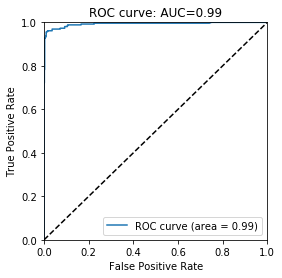

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=50,
                       min_samples_split=20, n_estimators=60,
                       random_state=2525)
acc: -0.07446040863992677
AUC curve : 0.992859


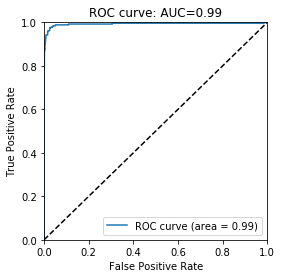

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=50,
                       min_samples_split=20, n_estimators=40,
                       random_state=2525)
acc: -0.10790345465945751
AUC curve : 0.983986


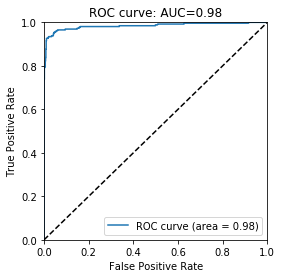

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=50,
                       min_samples_split=20, n_estimators=40,
                       random_state=2525)
acc: -0.0911497026564066
AUC curve : 0.992095


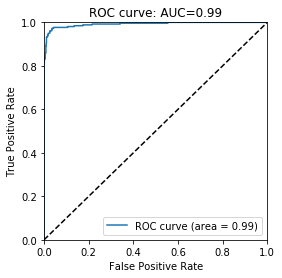

RandomForestClassifier(class_weight='balanced', max_depth=10, max_features=60,
                       min_samples_split=20, n_estimators=60,
                       random_state=2525)
acc: -0.07880249590192304
AUC curve : 0.994287


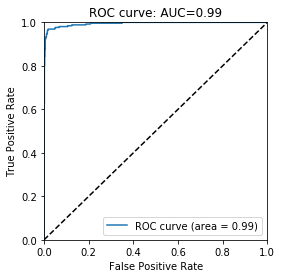

AUC curve : 0.991385


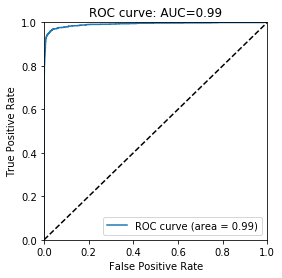

,MicroSEC mutation,MicroSEC artifact
RF_predicted_001 mutation,0,0
RF_predicted_001 artifact,3740,1294
RF_predicted_005 mutation,1580,4
RF_predicted_005 artifact,2160,1290
RF_predicted_01 mutation,2242,7
RF_predicted_01 artifact,1498,1287
RF_predicted_025 mutation,2740,11
RF_predicted_025 artifact,1000,1283
RF_predicted_05 mutation,3083,16
RF_predicted_05 artifact,657,1278


In [379]:
# Random forest classifier
# 5-fold cross validation
# Training:Validation:Test = 3:1:1

X_RF = np.array(X)
y_RF = np.array(y)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=242)
y_pred_total = []
y_proba_total_RF = []
y_true_RF = []
df_RF = pd.DataFrame([])

for train, test in skf.split(X_RF, y_RF):
    X_train = X_RF[train]
    X_test = X_RF[test]
    y_train = y_RF[train]
    y_test = y_RF[test]
    df_test = df_.iloc[test]

    search_params = {
        'n_estimators'      : [40, 50, 60],
        'max_features'      : [30, 40, 50, 60],
        'random_state'      : [2525],
        'min_samples_split' : [20],
        'max_depth'         : [10, 12, 15]
    }


    gs = GridSearchCV(RFC(class_weight='balanced'),
                      search_params,
                      cv=4,
                      verbose=False,
                      scoring='neg_log_loss',
                      n_jobs=-1)
    gs.fit(X_train, y_train)

    print(gs.best_estimator_)
    print(f"acc: {gs.score(X_test, y_test)}")
    y_pred = gs.predict(X_test)
    y_proba = gs.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("AUC curve : %f" % roc_auc)
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: AUC=%0.2f' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()
    y_pred_total = np.concatenate([y_pred_total, y_pred])
    y_proba_total_RF = np.concatenate([y_proba_total_RF, y_proba[:, 1]])
    y_true_RF = np.concatenate([y_true_RF, y_test])
    df_RF = pd.concat([df_RF, df_test])

fpr, tpr, thresholds = roc_curve(y_true_RF, y_proba_total_RF)
roc_auc = auc(fpr, tpr)
print ("AUC curve : %f" % roc_auc)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: AUC=%0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

y_pred_temp_001 = copy.deepcopy(y_proba_total_RF)
for i in range(len(y_proba_total_RF)):
    if y_proba_total_RF[i]>=0.001:
        y_pred_temp_001[i]=1
    else:
        y_pred_temp_001[i]=0

y_pred_temp_005 = copy.deepcopy(y_proba_total_RF)
for i in range(len(y_proba_total_RF)):
    if y_proba_total_RF[i]>=0.005:
        y_pred_temp_005[i]=1
    else:
        y_pred_temp_005[i]=0

y_pred_temp_01 = copy.deepcopy(y_proba_total_RF)
for i in range(len(y_proba_total_RF)):
    if y_proba_total_RF[i]>=0.01:
        y_pred_temp_01[i]=1
    else:
        y_pred_temp_01[i]=0

y_pred_temp_025 = copy.deepcopy(y_proba_total_RF)
for i in range(len(y_proba_total_RF)):
    if y_proba_total_RF[i]>=0.025:
        y_pred_temp_025[i]=1
    else:
        y_pred_temp_025[i]=0

y_pred_temp_05 = copy.deepcopy(y_proba_total_RF)
for i in range(len(y_proba_total_RF)):
    if y_proba_total_RF[i]>=0.05:
        y_pred_temp_05[i]=1
    else:
        y_pred_temp_05[i]=0

y_pred_temp_10 = copy.deepcopy(y_proba_total_RF)
for i in range(len(y_proba_total_RF)):
    if y_proba_total_RF[i]>=0.10:
        y_pred_temp_10[i]=1
    else:
        y_pred_temp_10[i]=0

y_pred_temp_25 = copy.deepcopy(y_proba_total_RF)
for i in range(len(y_proba_total_RF)):
    if y_proba_total_RF[i]>=0.25:
        y_pred_temp_25[i]=1
    else:
        y_pred_temp_25[i]=0

y_pred_temp_50 = copy.deepcopy(y_proba_total_RF)
for i in range(len(y_proba_total_RF)):
    if y_proba_total_RF[i]>=0.5:
        y_pred_temp_50[i]=1
    else:
        y_pred_temp_50[i]=0

y_pred_temp_75 = copy.deepcopy(y_proba_total_RF)
for i in range(len(y_proba_total_RF)):
    if y_proba_total_RF[i]>=0.75:
        y_pred_temp_75[i]=1
    else:
        y_pred_temp_75[i]=0

y_pred_temp_90 = copy.deepcopy(y_proba_total_RF)
for i in range(len(y_proba_total_RF)):
    if y_proba_total_RF[i]>=0.9:
        y_pred_temp_90[i]=1
    else:
        y_pred_temp_90[i]=0

y_pred_temp_95 = copy.deepcopy(y_proba_total_RF)
for i in range(len(y_proba_total_RF)):
    if y_proba_total_RF[i]>=0.95:
        y_pred_temp_95[i]=1
    else:
        y_pred_temp_95[i]=0

y_pred_temp_975 = copy.deepcopy(y_proba_total_RF)
for i in range(len(y_proba_total_RF)):
    if y_proba_total_RF[i]>=0.975:
        y_pred_temp_975[i]=1
    else:
        y_pred_temp_975[i]=0

y_pred_temp_99 = copy.deepcopy(y_proba_total_RF)
for i in range(len(y_proba_total_RF)):
    if y_proba_total_RF[i]>=0.99:
        y_pred_temp_99[i]=1
    else:
        y_pred_temp_99[i]=0

y_pred_temp_995 = copy.deepcopy(y_proba_total_RF)
for i in range(len(y_proba_total_RF)):
    if y_proba_total_RF[i]>=0.995:
        y_pred_temp_995[i]=1
    else:
        y_pred_temp_995[i]=0

y_pred_temp_999 = copy.deepcopy(y_proba_total_RF)
for i in range(len(y_proba_total_RF)):
    if y_proba_total_RF[i]>=0.999:
        y_pred_temp_999[i]=1
    else:
        y_pred_temp_999[i]=0


conf_matrix_RF = confusion_matrix(y_pred_temp_001, y_true_RF)
conf_matrix_RF = np.concatenate([conf_matrix_RF, confusion_matrix(y_pred_temp_005, y_true_RF)])
conf_matrix_RF = np.concatenate([conf_matrix_RF, confusion_matrix(y_pred_temp_01, y_true_RF)])
conf_matrix_RF = np.concatenate([conf_matrix_RF, confusion_matrix(y_pred_temp_025, y_true_RF)])
conf_matrix_RF = np.concatenate([conf_matrix_RF, confusion_matrix(y_pred_temp_05, y_true_RF)])
conf_matrix_RF = np.concatenate([conf_matrix_RF, confusion_matrix(y_pred_temp_10, y_true_RF)])
conf_matrix_RF = np.concatenate([conf_matrix_RF, confusion_matrix(y_pred_temp_25, y_true_RF)])
conf_matrix_RF = np.concatenate([conf_matrix_RF, confusion_matrix(y_pred_temp_50, y_true_RF)])
conf_matrix_RF = np.concatenate([conf_matrix_RF, confusion_matrix(y_pred_temp_75, y_true_RF)])
conf_matrix_RF = np.concatenate([conf_matrix_RF, confusion_matrix(y_pred_temp_90, y_true_RF)])
conf_matrix_RF = np.concatenate([conf_matrix_RF, confusion_matrix(y_pred_temp_95, y_true_RF)])
conf_matrix_RF = np.concatenate([conf_matrix_RF, confusion_matrix(y_pred_temp_975, y_true_RF)])
conf_matrix_RF = np.concatenate([conf_matrix_RF, confusion_matrix(y_pred_temp_99, y_true_RF)])
conf_matrix_RF = np.concatenate([conf_matrix_RF, confusion_matrix(y_pred_temp_995, y_true_RF)])
conf_matrix_RF = np.concatenate([conf_matrix_RF, confusion_matrix(y_pred_temp_999, y_true_RF)])



conf_table_RF = pd.DataFrame(conf_matrix_RF, index=['RF_predicted_001 mutation', 'RF_predicted_001 artifact', 
                                              'RF_predicted_005 mutation', 'RF_predicted_005 artifact',
                                              'RF_predicted_01 mutation', 'RF_predicted_01 artifact',
                                              'RF_predicted_025 mutation', 'RF_predicted_025 artifact',
                                              'RF_predicted_05 mutation', 'RF_predicted_05 artifact',
                                              'RF_predicted_10 mutation', 'RF_predicted_10 artifact',
                                              'RF_predicted_25 mutation', 'RF_predicted_25 artifact',
                                              'RF_predicted_50 mutation', 'RF_predicted_50 artifact',
                                              'RF_predicted_75 mutation', 'RF_predicted_75 artifact',
                                              'RF_predicted_90 mutation', 'RF_predicted_90 artifact',
                                              'RF_predicted_95 mutation', 'RF_predicted_95 artifact',
                                              'RF_predicted_97.5 mutation', 'RF_predicted_97.5 artifact',
                                              'RF_predicted_99 mutation', 'RF_predicted_99 artifact',
                                              'RF_predicted_99.5 mutation', 'RF_predicted_99.5 artifact',
                                              'RF_predicted_99.9 mutation', 'RF_predicted_99.9 artifact'],
                                             columns=['MicroSEC mutation', 'MicroSEC artifact'])

conf_table_RF

In [280]:
df_RF.loc[(0 + y_pred_temp_99) * (1 - y_true_RF) == 1]
#pd.set_option('display.max_rows', 150)
#pd.set_option('display.max_columns', 200)


#importance = pd.DataFrame(gs.best_estimator_.feature_importances_, index = X.columns, columns=["importance"])
#display(importance.sort_values("importance", ascending= False))
#importance.sum()
#importance.sort_values("importance", ascending= True).plot.barh(figsize = (8,16))
#importance.sort_values("importance", ascending= False)
#importance


,Unnamed: 0,index,Sample,Gene,HGVS.c,HGVS.p,Mut_type,Total_QV>=20,%Alt,Chr,Pos,Ref,Alt,SimpleRepeat_TRF,Neighborhood_sequence,Transition,read_length,total_read,soft_clipped_read,flag_hairpin,pre_support_length,post_support_length,short_support_length,low_quality_base_rate_under_q18,low_quality_pre,low_quality_post,distant_homology_rate,prob_filter_1,prob_filter_3_pre,prob_filter_3_post,filter_1_mutation_intra_hairpin_loop,filter_2_hairpin_structure,filter_3_microhomology_induced_mutation,filter_4_highly_homologous_region,filter_5_simple_repeat,filter_6_c_to_t_artifact,filter_7_mutation_at_homopolymer,filter_8_low_quality,msec_filter_123,msec_filter_1234,palindrome,search_seq_A,search_seq_B,search_seq_C,search_seq_D,rev_comp_seq,search_hairpin_A,search_hairpin_B,search_hairpin_C,search_hairpin_D,search_hairpin_E,possible_hairpin_A_1,possible_hairpin_A_2,possible_hairpin_A_3,possible_hairpin_A_4,possible_hairpin_A_5,possible_hairpin_A_6,possible_hairpin_B_1,possible_hairpin_B_2,possible_hairpin_B_3,possible_hairpin_B_4,possible_hairpin_B_5,possible_hairpin_B_6,possible_hairpin_C_1,possible_hairpin_C_2,possible_hairpin_C_3,possible_hairpin_C_4,possible_hairpin_C_5,possible_hairpin_C_6,possible_hairpin_D_1,possible_hairpin_D_2,possible_hairpin_D_3,possible_hairpin_D_4,possible_hairpin_D_5,possible_hairpin_D_6,possible_hairpin_E_1,possible_hairpin_E_2,possible_hairpin_E_3,possible_hairpin_E_4,possible_hairpin_E_5,possible_hairpin_E_6,score_20,score_25,score_30,score_35,score_40,score_45,score_50,score_55,score_60,score_A_20,score_A_25,score_A_30,score_A_35,score_A_40,score_A_45,score_A_50,score_A_55,score_A_60,score_B_20,score_B_25,score_B_30,score_B_35,score_B_40,score_B_45,score_B_50,score_B_55,score_B_60,score_C_20,score_C_25,score_C_30,score_C_35,score_C_40,score_C_45,score_C_50,score_C_55,score_C_60,score_D_20,score_D_25,score_D_30,score_D_35,score_D_40,score_D_45,score_D_50,score_D_55,score_D_60,possible_hairpin_A_7,possible_hairpin_A_8,possible_hairpin_A_9,possible_hairpin_A_A,possible_hairpin_A_B,possible_hairpin_A_C,possible_hairpin_A_D,possible_hairpin_A_E,possible_hairpin_A_F,possible_hairpin_A_G,possible_hairpin_A_H,possible_hairpin_A_I,possible_hairpin_B_7,possible_hairpin_B_8,possible_hairpin_B_9,possible_hairpin_B_A,possible_hairpin_B_B,possible_hairpin_B_C,possible_hairpin_B_D,possible_hairpin_B_E,possible_hairpin_B_F,possible_hairpin_B_G,possible_hairpin_B_H,possible_hairpin_B_I,possible_hairpin_C_7,possible_hairpin_C_8,possible_hairpin_C_9,possible_hairpin_C_A,possible_hairpin_C_B,possible_hairpin_C_C,possible_hairpin_C_D,possible_hairpin_C_E,possible_hairpin_C_F,possible_hairpin_C_G,possible_hairpin_C_H,possible_hairpin_C_I,possible_hairpin_D_7,possible_hairpin_D_8,possible_hairpin_D_9,possible_hairpin_D_A,possible_hairpin_D_B,possible_hairpin_D_C,possible_hairpin_D_D,possible_hairpin_D_E,possible_hairpin_D_F,possible_hairpin_D_G,possible_hairpin_D_H,possible_hairpin_D_I,possible_hairpin_E_7,possible_hairpin_E_8,possible_hairpin_E_9,possible_hairpin_E_A,possible_hairpin_E_B,possible_hairpin_E_C,possible_hairpin_E_D,possible_hairpin_E_E,possible_hairpin_E_F,possible_hairpin_E_G,possible_hairpin_E_H,possible_hairpin_E_I,check_1,check_2,check_3,check_4,check_5
5686,5686,3000,SL_0001_L_FFPE_26-B,KMT2B,c.3303T>A,p.Pro1101Pro,1-snv,679,5.00736,chr19,35723976,T,A,N,TCGGAGCCCGGGGGCCCCCCAGCTCCTCGGCGTCGGACCCC,T>A_g,150,118,54,1,149,139,71,0.006213,0.001571,0.003215,0.0,0.105191,0.715289,0.117849,False,False,False,False,False,False,False,False,False,False,tctcctgaggcctcccctggtcctccaggcccacgccggggggcgg...,CCCAGCT,CCCCAGCTC,GGCCCCCCA,AGCTCCTCG,1,CCCCAGCTC,CCCCCCAGCTCCT,GGCCCCCCAGCTCCTCG,GGGGCCCCCCAGCTCCTCGGC,CGGGGGCCCCCCAGCTCCTCGGCGT,9,9,9,9,9,9,12,12,12,12,12,12,15,14,15,14,14,14,17,16,17,16,16,16,17,16,17,16,16,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,12.0,15.0,14.0,14.0,

DecisionTreeClassifier(max_depth=7, min_samples_leaf=2, min_samples_split=6,
                       random_state=2525, splitter='random')
acc: 0.958291956305859
acc: 0.9692154915590864
AUC curve : 0.959132


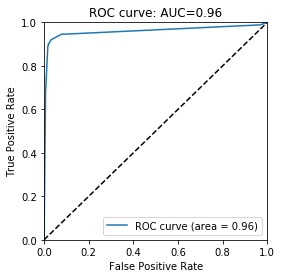

AUC curve : 0.985392


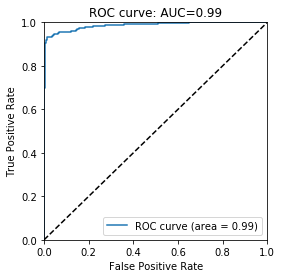

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=8,
                       random_state=2525)
acc: 0.9731876861966237
acc: 0.9801390268123138
AUC curve : 0.986654


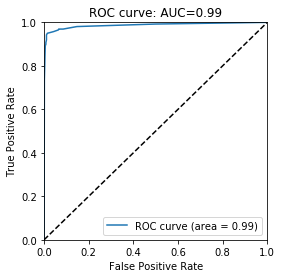

AUC curve : 0.990972


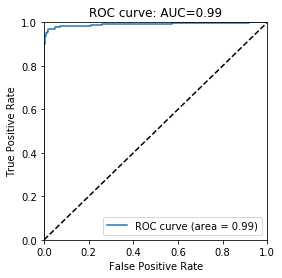

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=10,
                       random_state=2525)
acc: 0.9672293942403177
acc: 0.974180734856008
AUC curve : 0.984850


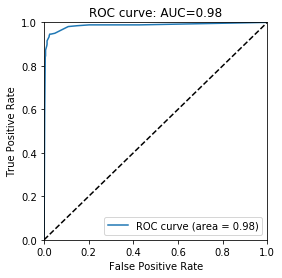

AUC curve : 0.992139


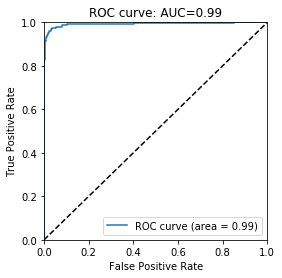

DecisionTreeClassifier(max_depth=8, min_samples_leaf=3, min_samples_split=10,
                       random_state=2525)
acc: 0.9622641509433962
acc: 0.971201588877855
AUC curve : 0.971897


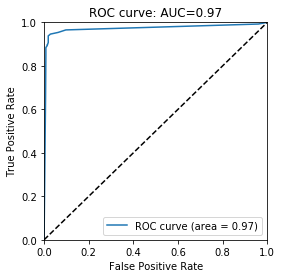

AUC curve : 0.993589


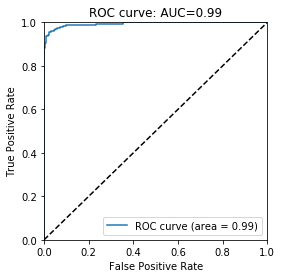

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=2,
                       min_samples_split=9, random_state=2525,
                       splitter='random')
acc: 0.9761431411530815
acc: 0.9840954274353877
AUC curve : 0.973327


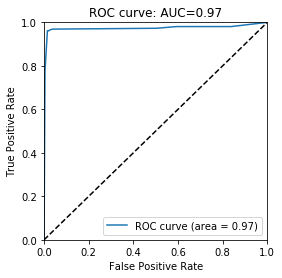

AUC curve : 0.998477


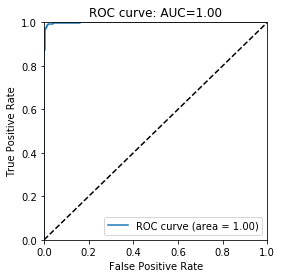

AUC curve : 0.977177


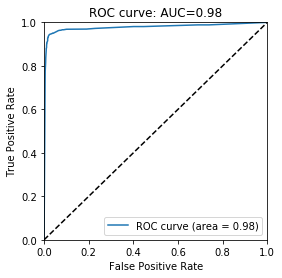

AUC curve : 0.986899


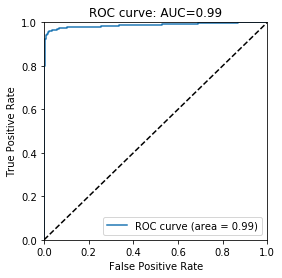

,MicroSEC mutation,MicroSEC artifact
DT_predicted_25 mutation,3650,72
DT_predicted_25 artifact,90,1222
DT_predicted_50 mutation,3680,95
DT_predicted_50 artifact,60,1199
DT_predicted_75 mutation,3694,122
DT_predicted_75 artifact,46,1172
DT_predicted_90 mutation,3699,151
DT_predicted_90 artifact,41,1143
DT_predicted_95 mutation,3712,211
DT_predicted_95 artifact,28,1083


In [380]:
# Decision tree cllasifier and ADABoost
# 5-fold cross validation
# Training:Validation:Test = 3:1:1

X_DT = np.array(X)
y_DT = np.array(y)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_total_DT = []
y_proba_total_DT = []
y_true_DT = []

y_pred_total_ADA = []
y_proba_total_ADA = []
y_true_ADA = []

for train, test in skf.split(X_DT, y_DT):
    X_train = X_DT[train]
    X_test = X_DT[test]
    y_train = y_DT[train]
    y_test = y_DT[test]
    #X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, shuffle=True, test_size=0.25, stratify=y_tv, random_state=100)

    search_params = {"criterion": ["gini", "entropy"],
                     "splitter": ["best", "random"],
                     "max_depth": [i for i in range(5, 11)],
                     "min_samples_split": [i for i in range(2, 11)],
                     "min_samples_leaf": [i for i in range(2, 11)],
                     "random_state": [2525]
                    }

    dt = GridSearchCV(DecisionTreeClassifier(),
                      search_params,
                      cv=4,
                      verbose=False,
                      n_jobs=-1)
    dt.fit(X_train, y_train)
    criterion_dt, max_depth_dt, min_samples_leaf_dt, min_samples_split_dt, random_state_dt, splitter_dt = dt.best_params_.values()
    ada = AdaBoostClassifier(DecisionTreeClassifier(criterion=criterion_dt, max_depth=max_depth_dt, min_samples_leaf=min_samples_leaf_dt, random_state=random_state_dt, splitter=splitter_dt))
    ada.fit(X_train, y_train)

    print(dt.best_estimator_)
    print(f"acc: {dt.score(X_test, y_test)}")
    print(f"acc: {ada.score(X_test, y_test)}")

    y_pred = dt.predict(X_test)
    y_proba = dt.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("AUC curve : %f" % roc_auc)
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: AUC=%0.2f' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()
    y_pred_total_DT = np.concatenate([y_pred_total_DT, y_pred])
    y_proba_total_DT = np.concatenate([y_proba_total_DT, y_proba[:, 1]])
    y_true_DT = np.concatenate([y_true_DT, y_test])

    y_pred = ada.predict(X_test)
    y_proba = ada.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("AUC curve : %f" % roc_auc)
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: AUC=%0.2f' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()
    y_pred_total_ADA = np.concatenate([y_pred_total_ADA, y_pred])
    y_proba_total_ADA = np.concatenate([y_proba_total_ADA, y_proba[:, 1]])
    y_true_ADA = np.concatenate([y_true_ADA, y_test])


fpr, tpr, thresholds = roc_curve(y_true_DT, y_proba_total_DT)
roc_auc = auc(fpr, tpr)
print ("AUC curve : %f" % roc_auc)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: AUC=%0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

fpr, tpr, thresholds = roc_curve(y_true_ADA, y_proba_total_ADA)
roc_auc = auc(fpr, tpr)
print ("AUC curve : %f" % roc_auc)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: AUC=%0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.show()


y_pred_temp_25 = copy.deepcopy(y_proba_total_DT)
for i in range(len(y_proba_total_DT)):
    if y_proba_total_DT[i]>=0.25:
        y_pred_temp_25[i]=1
    else:
        y_pred_temp_25[i]=0

y_pred_temp_50 = copy.deepcopy(y_proba_total_DT)
for i in range(len(y_proba_total_DT)):
    if y_proba_total_DT[i]>=0.5:
        y_pred_temp_50[i]=1
    else:
        y_pred_temp_50[i]=0

y_pred_temp_75 = copy.deepcopy(y_proba_total_DT)
for i in range(len(y_proba_total_DT)):
    if y_proba_total_DT[i]>=0.75:
        y_pred_temp_75[i]=1
    else:
        y_pred_temp_75[i]=0

y_pred_temp_90 = copy.deepcopy(y_proba_total_DT)
for i in range(len(y_proba_total_DT)):
    if y_proba_total_DT[i]>=0.9:
        y_pred_temp_90[i]=1
    else:
        y_pred_temp_90[i]=0

y_pred_temp_95 = copy.deepcopy(y_proba_total_DT)
for i in range(len(y_proba_total_DT)):
    if y_proba_total_DT[i]>=0.95:
        y_pred_temp_95[i]=1
    else:
        y_pred_temp_95[i]=0

y_pred_temp_975 = copy.deepcopy(y_proba_total_DT)
for i in range(len(y_proba_total_DT)):
    if y_proba_total_DT[i]>=0.975:
        y_pred_temp_975[i]=1
    else:
        y_pred_temp_975[i]=0

y_pred_temp_99 = copy.deepcopy(y_proba_total_DT)
for i in range(len(y_proba_total_DT)):
    if y_proba_total_DT[i]>=0.99:
        y_pred_temp_99[i]=1
    else:
        y_pred_temp_99[i]=0

conf_matrix_DT = confusion_matrix(y_pred_temp_25, y_true_DT)
conf_matrix_DT = np.concatenate([conf_matrix_DT, confusion_matrix(y_pred_temp_50, y_true_DT)])
conf_matrix_DT = np.concatenate([conf_matrix_DT, confusion_matrix(y_pred_temp_75, y_true_DT)])
conf_matrix_DT = np.concatenate([conf_matrix_DT, confusion_matrix(y_pred_temp_90, y_true_DT)])
conf_matrix_DT = np.concatenate([conf_matrix_DT, confusion_matrix(y_pred_temp_95, y_true_DT)])
conf_matrix_DT = np.concatenate([conf_matrix_DT, confusion_matrix(y_pred_temp_975, y_true_DT)])
conf_matrix_DT = np.concatenate([conf_matrix_DT, confusion_matrix(y_pred_temp_99, y_true_DT)])

conf_table_DT = pd.DataFrame(conf_matrix_DT, index=['DT_predicted_25 mutation', 'DT_predicted_25 artifact', 
                                              'DT_predicted_50 mutation', 'DT_predicted_50 artifact',
                                              'DT_predicted_75 mutation', 'DT_predicted_75 artifact',
                                              'DT_predicted_90 mutation', 'DT_predicted_90 artifact',
                                              'DT_predicted_95 mutation', 'DT_predicted_95 artifact',
                                              'DT_predicted_97.5 mutation', 'DT_predicted_97.5 artifact',
                                              'DT_predicted_99 mutation', 'DT_predicted_99 artifact'],
                                       columns=['MicroSEC mutation', 'MicroSEC artifact'])

y_pred_temp_25 = copy.deepcopy(y_proba_total_ADA)
for i in range(len(y_proba_total_ADA)):
    if y_proba_total_ADA[i]>=0.25:
        y_pred_temp_25[i]=1
    else:
        y_pred_temp_25[i]=0

y_pred_temp_50 = copy.deepcopy(y_proba_total_ADA)
for i in range(len(y_proba_total_ADA)):
    if y_proba_total_ADA[i]>=0.5:
        y_pred_temp_50[i]=1
    else:
        y_pred_temp_50[i]=0

y_pred_temp_75 = copy.deepcopy(y_proba_total_ADA)
for i in range(len(y_proba_total_ADA)):
    if y_proba_total_ADA[i]>=0.75:
        y_pred_temp_75[i]=1
    else:
        y_pred_temp_75[i]=0

y_pred_temp_90 = copy.deepcopy(y_proba_total_ADA)
for i in range(len(y_proba_total_ADA)):
    if y_proba_total_ADA[i]>=0.9:
        y_pred_temp_90[i]=1
    else:
        y_pred_temp_90[i]=0

y_pred_temp_95 = copy.deepcopy(y_proba_total_ADA)
for i in range(len(y_proba_total_ADA)):
    if y_proba_total_ADA[i]>=0.95:
        y_pred_temp_95[i]=1
    else:
        y_pred_temp_95[i]=0

y_pred_temp_975 = copy.deepcopy(y_proba_total_ADA)
for i in range(len(y_proba_total_ADA)):
    if y_proba_total_ADA[i]>=0.975:
        y_pred_temp_975[i]=1
    else:
        y_pred_temp_975[i]=0

y_pred_temp_99 = copy.deepcopy(y_proba_total_ADA)
for i in range(len(y_proba_total_ADA)):
    if y_proba_total_ADA[i]>=0.99:
        y_pred_temp_99[i]=1
    else:
        y_pred_temp_99[i]=0

conf_matrix_ADA = confusion_matrix(y_pred_temp_25, y_true_ADA)
conf_matrix_ADA = np.concatenate([conf_matrix_ADA, confusion_matrix(y_pred_temp_50, y_true_ADA)])
conf_matrix_ADA = np.concatenate([conf_matrix_ADA, confusion_matrix(y_pred_temp_75, y_true_ADA)])
conf_matrix_ADA = np.concatenate([conf_matrix_ADA, confusion_matrix(y_pred_temp_90, y_true_ADA)])
conf_matrix_ADA = np.concatenate([conf_matrix_ADA, confusion_matrix(y_pred_temp_95, y_true_ADA)])
conf_matrix_ADA = np.concatenate([conf_matrix_ADA, confusion_matrix(y_pred_temp_975, y_true_ADA)])
conf_matrix_ADA = np.concatenate([conf_matrix_ADA, confusion_matrix(y_pred_temp_99, y_true_ADA)])

conf_table_ADA = pd.DataFrame(conf_matrix_ADA, index=['ADA_predicted_25 mutation', 'ADA_predicted_25 artifact', 
                                              'ADA_predicted_50 mutation', 'ADA_predicted_50 artifact',
                                              'ADA_predicted_75 mutation', 'ADA_predicted_75 artifact',
                                              'ADA_predicted_90 mutation', 'ADA_predicted_90 artifact',
                                              'ADA_predicted_95 mutation', 'ADA_predicted_95 artifact',
                                              'ADA_predicted_97.5 mutation', 'ADA_predicted_97.5 artifact',
                                              'ADA_predicted_99 mutation', 'ADA_predicted_99 artifact'],
                                       columns=['MicroSEC mutation', 'MicroSEC artifact'])
pd.concat([conf_table_DT, conf_table_ADA], axis=0)



Fitting 4 folds for each of 100 candidates, totalling 400 fits
GaussianNB(var_smoothing=8.111308307896872e-05)
acc: -2.1923424935619042
AUC curve : 0.960776


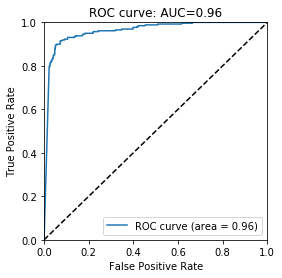

Fitting 4 folds for each of 100 candidates, totalling 400 fits
GaussianNB(var_smoothing=6.579332246575683e-05)
acc: -1.420786293719582
AUC curve : 0.974080


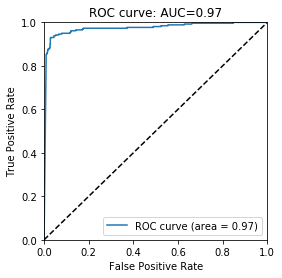

Fitting 4 folds for each of 100 candidates, totalling 400 fits
GaussianNB(var_smoothing=5.3366992312063123e-05)
acc: -1.781905112619696
AUC curve : 0.964162


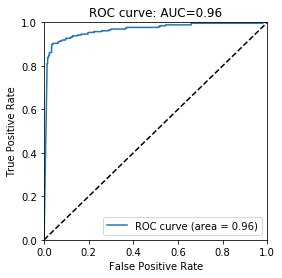

Fitting 4 folds for each of 100 candidates, totalling 400 fits
GaussianNB(var_smoothing=6.579332246575683e-05)
acc: -1.6805321136192093
AUC curve : 0.966794


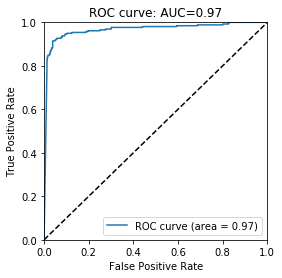

Fitting 4 folds for each of 100 candidates, totalling 400 fits
GaussianNB(var_smoothing=8.111308307896872e-05)
acc: -1.5823697380591015
AUC curve : 0.979014


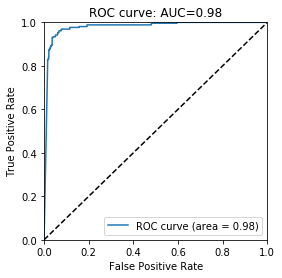

AUC curve : 0.967477


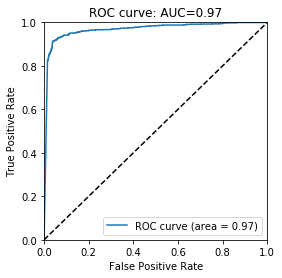

,MicroSEC mutation,MicroSEC artifact
GNB_predicted_25 mutation,3661,196
GNB_predicted_25 artifact,79,1098
GNB_predicted_50 mutation,3662,200
GNB_predicted_50 artifact,78,1094
GNB_predicted_75 mutation,3662,205
GNB_predicted_75 artifact,78,1089
GNB_predicted_90 mutation,3665,208
GNB_predicted_90 artifact,75,1086
GNB_predicted_95 mutation,3665,208
GNB_predicted_95 artifact,75,1086


In [381]:
# Naive Bayes
# 5-fold cross validation
# Training:Validation:Test = 3:1:1

X_GNB = np.array(X)
y_GNB = np.array(y)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_total_GNB = []
y_proba_total_GNB = []
y_true_GNB = []
for train, test in skf.split(X_GNB, y_GNB):
    X_train = X_GNB[train]
    X_test = X_GNB[test]
    y_train = y_GNB[train]
    y_test = y_GNB[test]
    #X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, shuffle=True, test_size=0.25, stratify=y_tv, random_state=100)

    search_params = {'var_smoothing': np.logspace(0,-9, num=100)}
    GNB = GridSearchCV(GaussianNB(),
                      search_params,
                      cv=4,
                      verbose=True,
                      scoring='neg_log_loss',
                      n_jobs=-1)
    GNB.fit(X_train, y_train)

    print(GNB.best_estimator_)
    print(f"acc: {GNB.score(X_test, y_test)}")
    y_pred = GNB.predict(X_test)
    y_proba = GNB.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("AUC curve : %f" % roc_auc)
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: AUC=%0.2f' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()
    y_pred_total_GNB = np.concatenate([y_pred_total_GNB, y_pred])
    y_proba_total_GNB = np.concatenate([y_proba_total_GNB, y_proba[:, 1]])
    y_true_GNB = np.concatenate([y_true_GNB, y_test])

fpr, tpr, thresholds = roc_curve(y_true_GNB, y_proba_total_GNB)
roc_auc = auc(fpr, tpr)
print ("AUC curve : %f" % roc_auc)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: AUC=%0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

y_pred_temp_25 = copy.deepcopy(y_proba_total_GNB)
for i in range(len(y_proba_total_GNB)):
    if y_proba_total_GNB[i]>=0.25:
        y_pred_temp_25[i]=1
    else:
        y_pred_temp_25[i]=0

y_pred_temp_50 = copy.deepcopy(y_proba_total_GNB)
for i in range(len(y_proba_total_GNB)):
    if y_proba_total_GNB[i]>=0.5:
        y_pred_temp_50[i]=1
    else:
        y_pred_temp_50[i]=0

y_pred_temp_75 = copy.deepcopy(y_proba_total_GNB)
for i in range(len(y_proba_total_GNB)):
    if y_proba_total_GNB[i]>=0.75:
        y_pred_temp_75[i]=1
    else:
        y_pred_temp_75[i]=0

y_pred_temp_90 = copy.deepcopy(y_proba_total_GNB)
for i in range(len(y_proba_total_GNB)):
    if y_proba_total_GNB[i]>=0.9:
        y_pred_temp_90[i]=1
    else:
        y_pred_temp_90[i]=0

y_pred_temp_95 = copy.deepcopy(y_proba_total_GNB)
for i in range(len(y_proba_total_GNB)):
    if y_proba_total_GNB[i]>=0.95:
        y_pred_temp_95[i]=1
    else:
        y_pred_temp_95[i]=0

y_pred_temp_975 = copy.deepcopy(y_proba_total_GNB)
for i in range(len(y_proba_total_GNB)):
    if y_proba_total_GNB[i]>=0.975:
        y_pred_temp_975[i]=1
    else:
        y_pred_temp_975[i]=0

y_pred_temp_99 = copy.deepcopy(y_proba_total_GNB)
for i in range(len(y_proba_total_GNB)):
    if y_proba_total_GNB[i]>=0.99:
        y_pred_temp_99[i]=1
    else:
        y_pred_temp_99[i]=0

conf_matrix_GNB = confusion_matrix(y_pred_temp_25, y_true_GNB)
conf_matrix_GNB = np.concatenate([conf_matrix_GNB, confusion_matrix(y_pred_temp_50, y_true_GNB)])
conf_matrix_GNB = np.concatenate([conf_matrix_GNB, confusion_matrix(y_pred_temp_75, y_true_GNB)])
conf_matrix_GNB = np.concatenate([conf_matrix_GNB, confusion_matrix(y_pred_temp_90, y_true_GNB)])
conf_matrix_GNB = np.concatenate([conf_matrix_GNB, confusion_matrix(y_pred_temp_95, y_true_GNB)])
conf_matrix_GNB = np.concatenate([conf_matrix_GNB, confusion_matrix(y_pred_temp_975, y_true_GNB)])
conf_matrix_GNB = np.concatenate([conf_matrix_GNB, confusion_matrix(y_pred_temp_99, y_true_GNB)])

conf_table_GNB = pd.DataFrame(conf_matrix_GNB, index=['GNB_predicted_25 mutation', 'GNB_predicted_25 artifact', 
                                              'GNB_predicted_50 mutation', 'GNB_predicted_50 artifact',
                                              'GNB_predicted_75 mutation', 'GNB_predicted_75 artifact',
                                              'GNB_predicted_90 mutation', 'GNB_predicted_90 artifact',
                                              'GNB_predicted_95 mutation', 'GNB_predicted_95 artifact',
                                              'GNB_predicted_97.5 mutation', 'GNB_predicted_97.5 artifact',
                                              'GNB_predicted_99 mutation', 'GNB_predicted_99 artifact'],
                                       columns=['MicroSEC mutation', 'MicroSEC artifact'])

conf_table_GNB

In [337]:
# AACR Project GENIE re-analysis with Random forest classifier

y_Genie_proba = gs.predict_proba(X_Genie)[:,1]
a = df_Genie_[y_Genie_proba>0.99]
a['Center'].value_counts()
#a.to_excel('/mnt/HDD8TB/MicroSEC/source/Predict_Genie_RFC_999.xlsx')

UCSF    403
MSK     186
DFCI    186
UHN      28
VICC     22
JHU       6
YALE      2
PHS       2
SCI       1
Name: Center, dtype: int64

In [140]:
df_Genie_['Center'].value_counts()

MSK     360552
DFCI    248508
UCSF     57141
UHN      34421
VICC     28307
JHU      11308
MDA       3679
YALE      3661
PHS       3333
SCI       2515
NKI       2326
VHIO      1299
UCHI        45
WAKE        34
CHOP        11
DUKE         6
Name: Center, dtype: int64

In [330]:
#df_Genie_
a

,Unnamed: 0,Unnamed: 0.1,index,Center,Chr,Sample,%Alt,Gene,HGVS.p,Pos,Mut_type,Ref,Alt,Neighborhood_sequence,ref_read,total_read,palindrome,search_seq_A,search_seq_B,search_seq_C,search_seq_D,rev_comp_seq,search_hairpin_A,search_hairpin_B,search_hairpin_C,search_hairpin_D,search_hairpin_E,possible_hairpin_A_1,possible_hairpin_A_2,possible_hairpin_A_3,possible_hairpin_A_4,possible_hairpin_A_5,possible_hairpin_A_6,possible_hairpin_B_1,possible_hairpin_B_2,possible_hairpin_B_3,possible_hairpin_B_4,possible_hairpin_B_5,possible_hairpin_B_6,possible_hairpin_C_1,possible_hairpin_C_2,possible_hairpin_C_3,possible_hairpin_C_4,possible_hairpin_C_5,possible_hairpin_C_6,possible_hairpin_D_1,possible_hairpin_D_2,possible_hairpin_D_3,possible_hairpin_D_4,possible_hairpin_D_5,possible_hairpin_D_6,possible_hairpin_E_1,possible_hairpin_E_2,possible_hairpin_E_3,possible_hairpin_E_4,possible_hairpin_E_5,possible_hairpin_E_6,score_A_20,score_A_25,score_A_30,score_A_35,score_A_40,score_A_45,score_A_50,score_A_55,score_A_60,score_B_20,score_B_25,score_B_30,score_B_35,score_B_40,score_B_45,score_B_50,score_B_55,score_B_60,score_C_20,score_C_25,score_C_30,score_C_35,score_C_40,score_C_45,score_C_50,score_C_55,score_C_60,score_D_20,score_D_25,score_D_30,score_D_35,score_D_40,score_D_45,score_D_50,score_D_55,score_D_60,possible_hairpin_A_7,possible_hairpin_A_8,possible_hairpin_A_9,possible_hairpin_A_0,possible_hairpin_A_A,possible_hairpin_A_B,possible_hairpin_A_C,possible_hairpin_A_D,possible_hairpin_A_E,possible_hairpin_A_F,possible_hairpin_A_G,possible_hairpin_A_H,possible_hairpin_A_I,possible_hairpin_B_7,possible_hairpin_B_8,possible_hairpin_B_9,possible_hairpin_B_0,possible_hairpin_B_A,possible_hairpin_B_B,possible_hairpin_B_C,possible_hairpin_B_D,possible_hairpin_B_E,possible_hairpin_B_F,possible_hairpin_B_G,possible_hairpin_B_H,possible_hairpin_B_I,possible_hairpin_C_7,possible_hairpin_C_8,possible_hairpin_C_9,possible_hairpin_C_0,possible_hairpin_C_A,possible_hairpin_C_B,possible_hairpin_C_C,possible_hairpin_C_D,possible_hairpin_C_E,possible_hairpin_C_F,possible_hairpin_C_G,possible_hairpin_C_H,possible_hairpin_C_I,possible_hairpin_D_7,possible_hairpin_D_8,possible_hairpin_D_9,possible_hairpin_D_0,possible_hairpin_D_A,possible_hairpin_D_B,possible_hairpin_D_C,possible_hairpin_D_D,possible_hairpin_D_E,possible_hairpin_D_F,possible_hairpin_D_G,possible_hairpin_D_H,possible_hairpin_D_I,possible_hairpin_E_7,possible_hairpin_E_8,possible_hairpin_E_9,possible_hairpin_E_0,possible_hairpin_E_A,possible_hairpin_E_B,possible_hairpin_E_C,possible_hairpin_E_D,possible_hairpin_E_E,possible_hairpin_E_F,possible_hairpin_E_G,possible_hairpin_E_H,possible_hairpin_E_I
33656,33656,33656,11644,DFCI,chr1,GENIE-DFCI-199807-2710260,15.322581,C1orf86,p.*157*,2124308,1-snv,G,A,CTCAGCCTCTCAAAGGGCTGAGATTACAGGCGTGAGCCACC,105.0,19.0,agtggtgcaatcatacttcactacagcctccaattcctggctcaag...,CTGAGAT,GCTGAGATT,AAGGGCTGA,AGATTACAG,0,GCTGAGATT,GGGCTGAGATTAC,AAGGGCTGAGATTACAG,CAAAGGGCTGAGATTACAGGC,CTCAAAGGGCTGAGATTACAGGCGT,6,6,6,6,6,6,7,7,7,7,7,7,9,7,8,7,7,7,10,8,8,7,7,7,10,8,8,7,7,7,34,34,34,33,32,30,22,11,8,33,33,33,33,32,30,22,11,8,33,33,33,32,31,29,21,9,6,27,27,27,27,27,26,19,10,7,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,6.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,8.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7.0
38176,38176,38176,5868,DFCI,chr1,GENIE-DFCI-089242-350474,34.693878,C1orf86,p.*157*,2124313,1-snv,A,G,CCTCTCAAAGGGCTGGGATTGCAGGCGTGAGCCACCGTGCC,96.0,51.0,tgcaatcatacttcactacagcctccaattcctggctcaagggaat...,ATTGCAG,GATTGCAGG,CTGGGATTG,GCAGGCGTG,0,GATTGCAGG,GGGATTGCAGGCG,CTGGGATTGCAGGCGTG,GGCTGGGATTGCAGGCGTGAG,AGGGCTGGGATTGCAGGCGTGAGCC,7,7,7,7,7,7,8,8,7,7,7,7,9,8,8,7,7,7,10,8,9,7,7,7,11,9,10,7,7,7,123,123,123,123,123,121,109,92,6,122,122,122,122,122,120,108,91,6,119,119,119,119,119,117,105,89,6,105,105,105,105,105,103,92,76,4,7.0,7.0,7.0,7.0,7.0,7.0,7.0,7

([array([5.08347683e-02, 1.81552744e-02, 1.37568316e-02, 1.23530733e-02,
         5.03481321e-03, 1.87167777e-03, 1.53477577e-03, 9.54555664e-04,
         6.92520776e-04, 7.48671109e-05]),
  array([0.02634478, 0.02153558, 0.01770708, 0.01415259, 0.01417303,
         0.00505764, 0.00255697, 0.00171544, 0.00126417, 0.00075589])],
 array([  5. ,  14.5,  24. ,  33.5,  43. ,  52.5,  62. ,  71.5,  81. ,
         90.5, 100. ]),
 <a list of 2 Lists of Patches objects>)

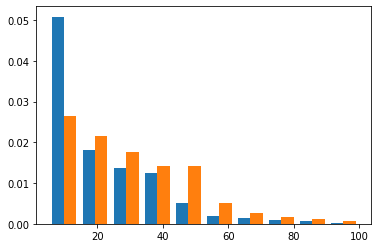

In [328]:
a = df_['%Alt']
#a = a[a<100]
#a = df_Genie_['%Alt']
#plt.hist(a, bins=100)
#plt.hist(df_Genie_['Sample'].value_counts(), bins=1000)
#a
b = df_Genie_['%Alt']
plt.hist([a, b], bins=10, density=True)



Fitting 4 folds for each of 4 candidates, totalling 16 fits
LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=0.7, learning_rate=0.005, max_depth=12,
               metric='binary_logloss', min_child_samples=5, n_estimators=4000,
               num_leaves=18, objective='binary', reg_alpha=0.05,
               reg_lambda=0.05)
acc: -0.07408119356959424
AUC curve : 0.993037


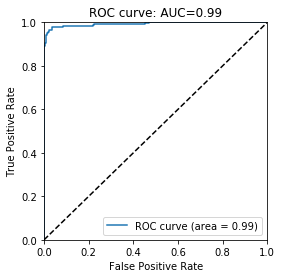

Fitting 4 folds for each of 4 candidates, totalling 16 fits
LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=0.7, learning_rate=0.005, max_depth=8,
               metric='binary_logloss', min_child_samples=5, n_estimators=4000,
               num_leaves=18, objective='binary', reg_alpha=0.05,
               reg_lambda=0.05)
acc: -0.06701393808618919
AUC curve : 0.997300


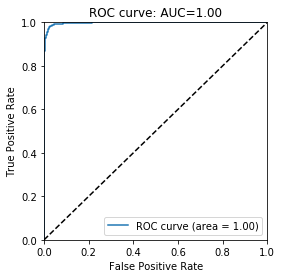

Fitting 4 folds for each of 4 candidates, totalling 16 fits
LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=0.7, learning_rate=0.005, max_depth=12,
               metric='binary_logloss', min_child_samples=5, n_estimators=4000,
               num_leaves=18, objective='binary', reg_alpha=0.05,
               reg_lambda=0.05)
acc: -0.06661965876019867
AUC curve : 0.995582


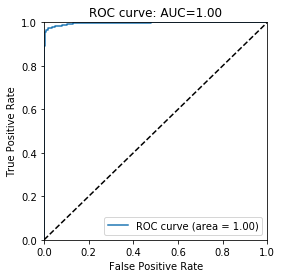

Fitting 4 folds for each of 4 candidates, totalling 16 fits
LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=0.7, learning_rate=0.005, max_depth=12,
               metric='binary_logloss', min_child_samples=5, n_estimators=4000,
               num_leaves=18, objective='binary', reg_alpha=0.05,
               reg_lambda=0.05)
acc: -0.05983785104833502
AUC curve : 0.997522


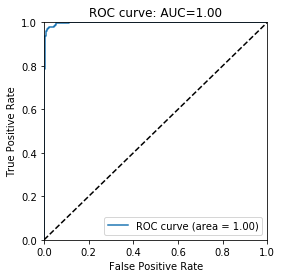

Fitting 4 folds for each of 4 candidates, totalling 16 fits
LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=0.7, learning_rate=0.005, max_depth=8,
               metric='binary_logloss', min_child_samples=5, n_estimators=4000,
               num_leaves=18, objective='binary', reg_alpha=0.05,
               reg_lambda=0.05)
acc: -0.0937425695077244
AUC curve : 0.991341


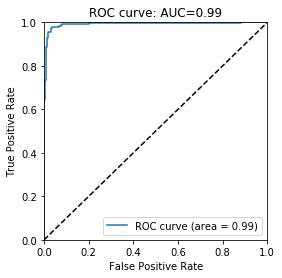

AUC curve : 0.994753


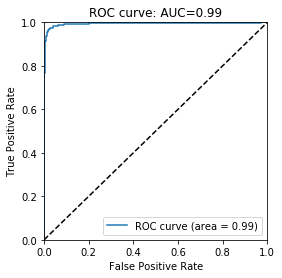

,MicroSEC mutation,MicroSEC artifact
LGB_predicted_005 mutation,1389,1
LGB_predicted_005 artifact,2351,1293
LGB_predicted_01 mutation,2432,4
LGB_predicted_01 artifact,1308,1290
LGB_predicted_025 mutation,2986,6
LGB_predicted_025 artifact,754,1288
LGB_predicted_05 mutation,3278,8
LGB_predicted_05 artifact,462,1286
LGB_predicted_10 mutation,3472,16
LGB_predicted_10 artifact,268,1278


In [382]:
# Light GBM
# 5-fold cross validation
# Training:Validation:Test = 3:1:1

X_LGB = np.array(X)
y_LGB = np.array(y)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=342)
y_pred_total_LGB = []
y_proba_total_LGB = []
y_true_LGB = []
df_LGB = pd.DataFrame([])

for train, test in skf.split(X_LGB, y_LGB):
    X_train = X_LGB[train]
    X_test = X_LGB[test]
    y_train = y_LGB[train]
    y_test = y_LGB[test]
    df_test = df_.iloc[test]

    lgbm = lgb.LGBMClassifier(objective='binary', class_weight='balanced')
    
    search_params = {'boosting_type':['dart'],
                     'learning_rate':[0.005],
                     'metric':['binary_logloss'],
                     'n_estimators':[4000],
                     'num_leaves':[20, 18],
                     'reg_alpha':[0.05],
                     'reg_lambda':[0.05],
                     'min_child_samples': [5],
                     'max_depth': [12, 8],
                     'colsample_bytree':[0.7]
                    }

    LGB = GridSearchCV(lgbm,
                      search_params,
                      cv=4,
                      verbose=True,
                      scoring='neg_log_loss',
                      n_jobs=-1)
    LGB.fit(X_train, y_train)

    print(LGB.best_estimator_)
    print(f"acc: {LGB.score(X_test, y_test)}")
    y_pred = LGB.predict(X_test)
    y_proba = LGB.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("AUC curve : %f" % roc_auc)
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: AUC=%0.2f' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()
    y_pred_total_LGB = np.concatenate([y_pred_total_LGB, y_pred])
    y_proba_total_LGB = np.concatenate([y_proba_total_LGB, y_proba[:, 1]])
    y_true_LGB = np.concatenate([y_true_LGB, y_test])
    df_LGB = pd.concat([df_LGB, df_test])


fpr, tpr, thresholds = roc_curve(y_true_LGB, y_proba_total_LGB)
roc_auc = auc(fpr, tpr)
print ("AUC curve : %f" % roc_auc)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: AUC=%0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

y_pred_temp_005 = copy.deepcopy(y_proba_total_LGB)
for i in range(len(y_proba_total_LGB)):
    if y_proba_total_LGB[i]>=0.005:
        y_pred_temp_005[i]=1
    else:
        y_pred_temp_005[i]=0

y_pred_temp_01 = copy.deepcopy(y_proba_total_LGB)
for i in range(len(y_proba_total_LGB)):
    if y_proba_total_LGB[i]>=0.01:
        y_pred_temp_01[i]=1
    else:
        y_pred_temp_01[i]=0

y_pred_temp_025 = copy.deepcopy(y_proba_total_LGB)
for i in range(len(y_proba_total_LGB)):
    if y_proba_total_LGB[i]>=0.025:
        y_pred_temp_025[i]=1
    else:
        y_pred_temp_025[i]=0

y_pred_temp_05 = copy.deepcopy(y_proba_total_LGB)
for i in range(len(y_proba_total_LGB)):
    if y_proba_total_LGB[i]>=0.05:
        y_pred_temp_05[i]=1
    else:
        y_pred_temp_05[i]=0

y_pred_temp_10 = copy.deepcopy(y_proba_total_LGB)
for i in range(len(y_proba_total_LGB)):
    if y_proba_total_LGB[i]>=0.10:
        y_pred_temp_10[i]=1
    else:
        y_pred_temp_10[i]=0

y_pred_temp_25 = copy.deepcopy(y_proba_total_LGB)
for i in range(len(y_proba_total_LGB)):
    if y_proba_total_LGB[i]>=0.25:
        y_pred_temp_25[i]=1
    else:
        y_pred_temp_25[i]=0

y_pred_temp_50 = copy.deepcopy(y_proba_total_LGB)
for i in range(len(y_proba_total_LGB)):
    if y_proba_total_LGB[i]>=0.5:
        y_pred_temp_50[i]=1
    else:
        y_pred_temp_50[i]=0

y_pred_temp_75 = copy.deepcopy(y_proba_total_LGB)
for i in range(len(y_proba_total_LGB)):
    if y_proba_total_LGB[i]>=0.75:
        y_pred_temp_75[i]=1
    else:
        y_pred_temp_75[i]=0

y_pred_temp_90 = copy.deepcopy(y_proba_total_LGB)
for i in range(len(y_proba_total_LGB)):
    if y_proba_total_LGB[i]>=0.9:
        y_pred_temp_90[i]=1
    else:
        y_pred_temp_90[i]=0

y_pred_temp_95 = copy.deepcopy(y_proba_total_LGB)
for i in range(len(y_proba_total_LGB)):
    if y_proba_total_LGB[i]>=0.95:
        y_pred_temp_95[i]=1
    else:
        y_pred_temp_95[i]=0

y_pred_temp_975 = copy.deepcopy(y_proba_total_LGB)
for i in range(len(y_proba_total_LGB)):
    if y_proba_total_LGB[i]>=0.975:
        y_pred_temp_975[i]=1
    else:
        y_pred_temp_975[i]=0

y_pred_temp_99 = copy.deepcopy(y_proba_total_LGB)
for i in range(len(y_proba_total_LGB)):
    if y_proba_total_LGB[i]>=0.99:
        y_pred_temp_99[i]=1
    else:
        y_pred_temp_99[i]=0

y_pred_temp_995 = copy.deepcopy(y_proba_total_LGB)
for i in range(len(y_proba_total_LGB)):
    if y_proba_total_LGB[i]>=0.995:
        y_pred_temp_995[i]=1
    else:
        y_pred_temp_995[i]=0

y_pred_temp_999 = copy.deepcopy(y_proba_total_LGB)
for i in range(len(y_proba_total_LGB)):
    if y_proba_total_LGB[i]>=0.999:
        y_pred_temp_999[i]=1
    else:
        y_pred_temp_999[i]=0


conf_matrix_LGB = confusion_matrix(y_pred_temp_005, y_true_LGB)
conf_matrix_LGB = np.concatenate([conf_matrix_LGB, confusion_matrix(y_pred_temp_01, y_true_LGB)])
conf_matrix_LGB = np.concatenate([conf_matrix_LGB, confusion_matrix(y_pred_temp_025, y_true_LGB)])
conf_matrix_LGB = np.concatenate([conf_matrix_LGB, confusion_matrix(y_pred_temp_05, y_true_LGB)])
conf_matrix_LGB = np.concatenate([conf_matrix_LGB, confusion_matrix(y_pred_temp_10, y_true_LGB)])
conf_matrix_LGB = np.concatenate([conf_matrix_LGB, confusion_matrix(y_pred_temp_25, y_true_LGB)])
conf_matrix_LGB = np.concatenate([conf_matrix_LGB, confusion_matrix(y_pred_temp_50, y_true_LGB)])
conf_matrix_LGB = np.concatenate([conf_matrix_LGB, confusion_matrix(y_pred_temp_75, y_true_LGB)])
conf_matrix_LGB = np.concatenate([conf_matrix_LGB, confusion_matrix(y_pred_temp_90, y_true_LGB)])
conf_matrix_LGB = np.concatenate([conf_matrix_LGB, confusion_matrix(y_pred_temp_95, y_true_LGB)])
conf_matrix_LGB = np.concatenate([conf_matrix_LGB, confusion_matrix(y_pred_temp_975, y_true_LGB)])
conf_matrix_LGB = np.concatenate([conf_matrix_LGB, confusion_matrix(y_pred_temp_99, y_true_LGB)])
conf_matrix_LGB = np.concatenate([conf_matrix_LGB, confusion_matrix(y_pred_temp_995, y_true_LGB)])
conf_matrix_LGB = np.concatenate([conf_matrix_LGB, confusion_matrix(y_pred_temp_999, y_true_LGB)])



conf_table_LGB = pd.DataFrame(conf_matrix_LGB, index=['LGB_predicted_005 mutation', 'LGB_predicted_005 artifact', 
                                              'LGB_predicted_01 mutation', 'LGB_predicted_01 artifact',
                                              'LGB_predicted_025 mutation', 'LGB_predicted_025 artifact',
                                              'LGB_predicted_05 mutation', 'LGB_predicted_05 artifact',
                                              'LGB_predicted_10 mutation', 'LGB_predicted_10 artifact',
                                              'LGB_predicted_25 mutation', 'LGB_predicted_25 artifact',
                                              'LGB_predicted_50 mutation', 'LGB_predicted_50 artifact',
                                              'LGB_predicted_75 mutation', 'LGB_predicted_75 artifact',
                                              'LGB_predicted_90 mutation', 'LGB_predicted_90 artifact',
                                              'LGB_predicted_95 mutation', 'LGB_predicted_95 artifact',
                                              'LGB_predicted_97.5 mutation', 'LGB_predicted_97.5 artifact',
                                              'LGB_predicted_99 mutation', 'LGB_predicted_99 artifact',
                                              'LGB_predicted_99.5 mutation', 'LGB_predicted_99.5 artifact',
                                              'LGB_predicted_99.9 mutation', 'LGB_predicted_99.9 artifact'],
                                             columns=['MicroSEC mutation', 'MicroSEC artifact'])

conf_table_LGB

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true_LGB, y_pred_total_LGB)
roc_auc = auc(fpr, tpr)
label = 'LightGBM' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)

fpr, tpr, thresholds = roc_curve(y_true_GNB, y_pred_total_GNB)
roc_auc = auc(fpr, tpr)
label = 'Naive Bayes' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)

fpr, tpr, thresholds = roc_curve(y_true_RF, y_pred_total_RF)
roc_auc = auc(fpr, tpr)
label = 'Logistic regression' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)

fpr, tpr, thresholds = roc_curve(y_true_DT, y_pred_total_DT)
roc_auc = auc(fpr, tpr)
label = 'Decision tree classifier' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)

fpr, tpr, thresholds = roc_curve(y_true_ADA, y_pred_total_ADA)
roc_auc = auc(fpr, tpr)
label = 'ADABoost' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_total)
roc_auc = auc(fpr, tpr)
label = 'Random forest classifier' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)





plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right")
plt.show()

fpr, tpr, thresholds = roc_curve(y_true, y_proba_total)
roc_auc = auc(fpr, tpr)
print ("Random forest classifier AUC curve : %f" % roc_auc)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: AUC=%0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

pd.concat([conf_table, conf_table_LGB], axis=0)

AttributeError: 'Functional' object has no attribute 'feature_importances_'

In [107]:
y_NN
np.array([[0], [1], [1], [1]])
x2 = np.arange(0, 1, 0.01)
y2 = x2**2

y2
y_NN

array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
# Neural network
# 5-fold cross validation
# Training:Validation:Test = 3:1:1
baseSaveDir = "/mnt/HDD8TB/MicroSEC/source/checkpoint/"
def getNewestModel(model, dirname):
    from glob import glob
    target = os.path.join(dirname, '*')
    files = [(f, os.path.getmtime(f)) for f in glob(target)]
    if len(files) == 0:
        return model
    else:
        newestModel = sorted(files, key=lambda files: files[1])[-1]
        model.load_weights(newestModel[0])
        return model


mm = preprocessing.MinMaxScaler()
#X_NN = mm.fit_transform(np.array(X))
X_NN = (np.array(X))

#y_NN = preprocessing.minmax_scale(np.array(y))
y_NN = np.array(y)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_pred_total_NN = []
y_proba_total_NN = []
y_true_NN = []
for train, test in skf.split(X_NN, y_NN):
    X_tv = X_NN[train]
    X_test = X_NN[test]
    y_tv = y_NN[train]
    y_test = y_NN[test]

    y_tv = to_categorical(y_tv)
    y_test = to_categorical(y_test)

    inputs = keras.Input(shape=(72,))
    x = layers.Dense(4096, activation='relu')(inputs)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    outputs = layers.Dense(2, activation='softmax')(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name='NN_model')

    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.SGD(learning_rate=0.01),
                  metrics=['acc'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=100, verbose=0) 
    chkpt = os.path.join(baseSaveDir, 'NN_model.hdf5')
    cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=0, save_best_only=True, mode='auto')
    reduce_lr = ReduceLROnPlateau(
                        monitor='val_loss',
                        factor=0.9,
                        patience=5,
                        min_lr=0.001)

    history = model.fit(X_tv, y_tv,
                        batch_size=128,
                        epochs=500,
                        verbose=1,
                        callbacks=[early_stopping, cp_cb, reduce_lr],
                        validation_split=0.25,
                        shuffle=True)
    model = getNewestModel(model, baseSaveDir)

    test_scores = model.evaluate(X_test, y_test, verbose=2)
    print('Test loss:', test_scores[0])
    print('Test accuracy:', test_scores[1])

    y_pred = model.predict(X_test)
    y_proba = model.predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("AUC curve : %f" % roc_auc)
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: AUC=%0.2f' % roc_auc)
    plt.legend(loc="lower right")
    plt.show()
    y_pred_total_NN = np.concatenate([y_pred_total_NN, y_pred[:, 1]])
    y_proba_total_NN = np.concatenate([y_proba_total_NN, y_proba[:, 1]])
    y_true_NN = np.concatenate([y_true_NN, y_test[:, 1]])

fpr, tpr, thresholds = roc_curve(y_true_NN, y_proba_total_NN)
roc_auc = auc(fpr, tpr)
print ("AUC curve : %f" % roc_auc)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve: AUC=%0.2f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

y_pred_temp_25 = copy.deepcopy(y_proba_total_NN)
for i in range(len(y_proba_total_NN)):
    if y_proba_total_NN[i]>=0.25:
        y_pred_temp_25[i]=1
    else:
        y_pred_temp_25[i]=0

y_pred_temp_50 = copy.deepcopy(y_proba_total_NN)
for i in range(len(y_proba_total_NN)):
    if y_proba_total_NN[i]>=0.5:
        y_pred_temp_50[i]=1
    else:
        y_pred_temp_50[i]=0

y_pred_temp_75 = copy.deepcopy(y_proba_total_NN)
for i in range(len(y_proba_total_NN)):
    if y_proba_total_NN[i]>=0.75:
        y_pred_temp_75[i]=1
    else:
        y_pred_temp_75[i]=0

y_pred_temp_90 = copy.deepcopy(y_proba_total_NN)
for i in range(len(y_proba_total_NN)):
    if y_proba_total_NN[i]>=0.9:
        y_pred_temp_90[i]=1
    else:
        y_pred_temp_90[i]=0

y_pred_temp_95 = copy.deepcopy(y_proba_total_NN)
for i in range(len(y_proba_total_NN)):
    if y_proba_total_NN[i]>=0.95:
        y_pred_temp_95[i]=1
    else:
        y_pred_temp_95[i]=0

y_pred_temp_975 = copy.deepcopy(y_proba_total_NN)
for i in range(len(y_proba_total_NN)):
    if y_proba_total_NN[i]>=0.975:
        y_pred_temp_975[i]=1
    else:
        y_pred_temp_975[i]=0

y_pred_temp_99 = copy.deepcopy(y_proba_total_NN)
for i in range(len(y_proba_total_NN)):
    if y_proba_total_NN[i]>=0.99:
        y_pred_temp_99[i]=1
    else:
        y_pred_temp_99[i]=0

conf_matrix_NN = confusion_matrix(y_pred_temp_25, y_true_NN)
conf_matrix_NN = np.concatenate([conf_matrix_NN, confusion_matrix(y_pred_temp_50, y_true_NN)])
conf_matrix_NN = np.concatenate([conf_matrix_NN, confusion_matrix(y_pred_temp_75, y_true_NN)])
conf_matrix_NN = np.concatenate([conf_matrix_NN, confusion_matrix(y_pred_temp_90, y_true_NN)])
conf_matrix_NN = np.concatenate([conf_matrix_NN, confusion_matrix(y_pred_temp_95, y_true_NN)])
conf_matrix_NN = np.concatenate([conf_matrix_NN, confusion_matrix(y_pred_temp_975, y_true_NN)])
conf_matrix_NN = np.concatenate([conf_matrix_NN, confusion_matrix(y_pred_temp_99, y_true_NN)])

conf_table_NN = pd.DataFrame(conf_matrix_NN, index=['NN_predicted_25 mutation', 'NN_predicted_25 artifact', 
                                              'NN_predicted_50 mutation', 'NN_predicted_50 artifact',
                                              'NN_predicted_75 mutation', 'NN_predicted_75 artifact',
                                              'NN_predicted_90 mutation', 'NN_predicted_90 artifact',
                                              'NN_predicted_95 mutation', 'NN_predicted_95 artifact',
                                              'NN_predicted_97.5 mutation', 'NN_predicted_97.5 artifact',
                                              'NN_predicted_99 mutation', 'NN_predicted_99 artifact'],
                                       columns=['MicroSEC mutation', 'MicroSEC artifact'])

conf_table_NN

In [ ]:
plt.figure(figsize=(10,10))

fpr, tpr, thresholds = roc_curve(y_true_LGB, y_proba_total_LGB)
roc_auc = auc(fpr, tpr)
label = 'LightGBM' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)

fpr, tpr, thresholds = roc_curve(y_true_GNB, y_proba_total_GNB)
roc_auc = auc(fpr, tpr)
label = 'Naive Bayes' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)

fpr, tpr, thresholds = roc_curve(y_true_LR, y_proba_total_LR)
roc_auc = auc(fpr, tpr)
label = 'Logistic regression' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)

fpr, tpr, thresholds = roc_curve(y_true_DT, y_proba_total_DT)
roc_auc = auc(fpr, tpr)
label = 'Decision tree classifier' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)

fpr, tpr, thresholds = roc_curve(y_true_ADA, y_proba_total_ADA)
roc_auc = auc(fpr, tpr)
label = 'ADABoost' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)

fpr, tpr, thresholds = roc_curve(y_true, y_proba_total)
roc_auc = auc(fpr, tpr)
label = 'Random forest classifier' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 0.2])
plt.ylim([0.8, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(10,10))

fpr, tpr, thresholds = roc_curve(y_true_LGB, y_proba_total_LGB)
roc_auc = auc(fpr, tpr)
label = 'LightGBM' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)

fpr, tpr, thresholds = roc_curve(y_true_GNB, y_proba_total_GNB)
roc_auc = auc(fpr, tpr)
label = 'Naive Bayes' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)

fpr, tpr, thresholds = roc_curve(y_true_LR, y_proba_total_LR)
roc_auc = auc(fpr, tpr)
label = 'Logistic regression' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)

fpr, tpr, thresholds = roc_curve(y_true_DT, y_proba_total_DT)
roc_auc = auc(fpr, tpr)
label = 'Decision tree classifier' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)

fpr, tpr, thresholds = roc_curve(y_true_ADA, y_proba_total_ADA)
roc_auc = auc(fpr, tpr)
label = 'ADABoost' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)

fpr, tpr, thresholds = roc_curve(y_true, y_proba_total)
roc_auc = auc(fpr, tpr)
label = 'Random forest classifier' + ' (AUC={:.3f})'.format(auc(fpr, tpr))
plt.plot(fpr, tpr, label=label)


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves')
plt.legend(loc="lower right")
plt.show()




In [56]:
model.shape

AttributeError: 'Functional' object has no attribute 'shape'